In [1]:
##                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import constants as c
from astropy.wcs import WCS
from astropy.io import fits
################################################################################################################################
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
import pandas as pd
################################################################################################################################
#-------------------------------------------------------------------------------------------------------------------------------
from astropy.utils import data 
from skimage.transform import rotate
from skimage.transform import resize
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage

In [2]:
# Filing Structure
'''
Streamlines the filing structure. This structure will then be appl
'''
pass_num = 'Pass1'
drive = '/home/andy'
root = f'{drive}/Desktop/Masters2020/RotationCurves/CubeStacker'
subroot = f'{root}/{pass_num}'

# In Case of Emergency: Break Glass

In [3]:
properties = pd.read_csv(f'{drive}/Desktop/FinalProduct/MasterTables/MasterTable_ NSA and Noordermeer - arcseconds.csv')
#sample = properties.UGC.tolist()
Groups = pd.read_csv(f'{drive}/Desktop/FinalProduct/CubeStacker2.0/Stack_Groups.csv')
Sample = 'Group_1'
#sample = [i for i in Groups[Sample] if i!=0]
#sample.append(i for i in [89,94])
sample = [508, 2487, 4458, 6118, 9644, 11914]
sample

[508, 2487, 4458, 6118, 9644, 11914]

# Cube manipulation Functions

In [4]:
def make_odd_cube(cube,edge=['r','r','r']):
    '''
    #updated 17 May: previously trim_cube()
    #Inserted on 16 May 2021: For idealised book-keeping, the raw cubes will be trimmed to be 
    odd-dimensional, benefitting the later steps in the pipeline, and ensuring that the 
    position of (CRPIX) will not change wrt the edges of the cube.
    '''
    trimmed_cube = cube
    
    if (cube.shape[0]%2 == 0):
        if edge[0]=='r':
            trimmed_cube = trimmed_cube[:-1,:,:]
        elif edge[0]=='l':
            trimmed_cube = trimmed_cube[1:,:,:]
            
    if (cube.shape[1]%2 == 0):
        if edge[1]=='r':
            trimmed_cube = trimmed_cube[:,:-1,:]
        elif edge[1]=='l':
            trimmed_cube = trimmed_cube[:,1:,:]
            
    if (cube.shape[2]%2 == 0):
        if edge[2]=='r':
            trimmed_cube = trimmed_cube[:,:,:-1]
        elif edge[2]=='l':
            trimmed_cube = trimmed_cube[:,:,1:]
            
    return(trimmed_cube)

def make_even_cube(cube,edge=['r','r','r']):
    '''
    #added 17 May 2021
    #previously trim_cube()
    #Inserted on 16 May 2021: For idealised book-keeping, the raw cubes will be trimmed to be 
    even-dimensional, benefitting the later steps in the pipeline, and ensuring that the 
    position of (CRPIX) will not change wrt the edges of the cube.
    '''
    trimmed_cube = cube
    
    if (cube.shape[0]%2 != 0):
        if edge[0]=='r':
            trimmed_cube = trimmed_cube[:-1,:,:]
        elif edge[0]=='l':
            trimmed_cube = trimmed_cube[1:,:,:]
            
    if (cube.shape[1]%2 != 0):
        if edge[1]=='r':
            trimmed_cube = trimmed_cube[:,:-1,:]
        elif edge[1]=='l':
            trimmed_cube = trimmed_cube[:,1:,:]
            
    if (cube.shape[2]%2 != 0):
        if edge[2]=='r':
            trimmed_cube = trimmed_cube[:,:,:-1]
        elif edge[2]=='l':
            trimmed_cube = trimmed_cube[:,:,1:]  
            
    return(trimmed_cube)

In [5]:
def update_header(ofile,ufile,beam_copy=False):
    original_cube = fits.open(ofile)
    updated_cube = fits.open(ufile)
    
    o_hdr = original_cube[0].header
    u_hdr = updated_cube[0].header

    u_hdr['PA'] = o_hdr['PA']  #degree
    u_hdr['I'] = o_hdr['I']  #degree
    u_hdr['MB'] = o_hdr['MB'] #mags
    u_hdr['Vhel'] = o_hdr['Vhel'] #km/s
    u_hdr['RHIARC'] = o_hdr['RHIARC'] #arcseconds
    u_hdr['W20'] = o_hdr['W20'] #km/s
    
    u_hdr['RA'] = o_hdr['RA']
    u_hdr['DEC'] = o_hdr['DEC']
    u_hdr['VHEL'] = o_hdr['VHEL']   
    u_hdr['EPOCH'] = 2000.0
    u_hdr['FREQ0'] = o_hdr['FREQ0']
    u_hdr['BUNIT'] = 'mJy/beam'        #changed from 'W.U.'
    u_hdr['POINTN'] = o_hdr['POINTN']
    
    if beam_copy == True:
        u_hdr['BEAMA'] = o_hdr['BEAMA']
        u_hdr['BEAMB'] = o_hdr['BEAMB']
        u_hdr['BEAMV'] = o_hdr['BEAMV']
        
        u_hdr['BMIN'] = o_hdr['BMIN']
        u_hdr['BMAJ'] = o_hdr['BMAJ']
        u_hdr['BPA'] = o_hdr['BPA']
        

    updated_cube.writeto(ufile,overwrite=True)

def get_opt_restfreq(cube):
    hdr = cube.header
    vr =  (hdr['Vhel'])*(u.km/u.s)                                               
    C = c.c.to(u.km/u.s)
    vHI =  1420.40575*u.MHz #https://www.astro.rug.nl/~whisp/WhispProject/ProjectDescription/ObservingParameters/observing_parameters.html
    rest_freq = vHI/(1+(vr/C))
    return(rest_freq)

def vel2freq(vr):
    C = c.c.to(u.km/u.s)
    vHI =  1420.40575*u.MHz #https://www.astro.rug.nl/~whisp/WhispProject/ProjectDescription/ObservingParameters/observing_parameters.html
    rest_freq = vHI/(1+(vr/C))
    return(rest_freq)

def freq2vel(freq):
    C = c.c.to(u.km/u.s)
    vHI =  1420.40575*u.MHz #https://www.astro.rug.nl/~whisp/WhispProject/ProjectDescription/ObservingParameters/observing_parameters.html
    rest_vel = (-1 + (freq/vHI))*C
    return(rest_vel)

def get_centre(cube,fits_cen=False):
    '''
    #Updated 7 May 2021: moving away from CRPIX as the standard, since CRPIX 
    does not automatically update following a transformation.
    
    input:
    cube: SpectralCube object   (Z,Y,X)
    fits_cen: bool (optional)
    ourput: 
    numpy array (X,Y,Z)
    Description:
    This function takes in a SpectralCube object, measuring the number of pixels along 
    each dimension, returning the coordinates of the  voxel in the centre of the cube. 
    (Possibly redundant since our pipeline ensures odd-dimensional cubes)
    
    '''
    if fits_cen is True:
        shift = 0
    elif fits_cen is False:
        #print('shifting')
        shift = -1

    centres = np.ones(3)
    for dim in [0,1,2]:
        dimension = cube.shape[dim]
        if dimension%2==0:
            centres[dim] = int((int(dimension/2))+shift)
        else:
            centres[dim] = int((int((dimension+1)/2))+shift)
    return(np.array([centres[2],centres[1],centres[0]]))


# A.) Append Properties to Cube Headers

In [6]:
vHI =  1420.40575*u.MHz
PA = pd.read_csv(f'{root}/properties.csv')

Optical = np.genfromtxt(f'{drive}/Desktop/Masters2020/MasterTables/Optical/NoordermeerOpticalMasterDegrees.csv',delimiter=',',skip_header=1).T
HyperledaNoordermeer = np.genfromtxt(f'{drive}/Desktop/Masters2020/Tables/Hyperleda/Noordermeer2005HyperledaValues.csv',delimiter=',',skip_header=1).T
Vhelio = HyperledaNoordermeer[1]
regridding_table = pd.read_csv(f'{drive}/Desktop/Masters2020/bitsNpieces/regrid_datacubes/Transformed_Header_Info.csv')
better_vels = pd.read_csv(f'{drive}/Desktop/Masters2020/bitsNpieces/better_spectral_extraction/remeasured_projected_beam_width_RC_weightedfit_values_updated.csv')

UGC  = PA['UGC']
inc  = PA['i']
Vhel = PA['Vel']
M    = PA['MB']
pa   = PA['PA']
ra_2000   = PA['RA [J2000]']#PA[5]
dec_2000  = PA['DEC [J2000]']#PA[6]
ra_1950   = PA['RA [B1950]']#PA[5]
dec_1950  = PA['DEC [B1950]']#PA[6]
R25arc  = PA['RHI[“]']
W20 = PA['W20']
BEAM_RA = PA['BEAM_RA [“]']
BEAM_DEC = PA['BEAM_DEC [“]']
BEAM_V = PA['BEAM_V [km/s]']

In [7]:
sample

[508, 2487, 4458, 6118, 9644, 11914]

In [8]:

cdelts = []
C = c.c.to(u.km/u.s)
flagged = [2141,2154,2941,3382,3580,3965,3993,4862,5060,5253,5906,5960,6001,6283,6742,7166
           ,7256,7489,7506,7704,7989,8271,8805,9644,10448,11951,12043,12276,12713]

for ugcNumb in sample:
    file = ugcNumb
    filename = f'{drive}/Desktop/Masters2020/RawCubes/Raw/u{(int(ugcNumb))}cl.fits'
    updated_filename = f'{subroot}/URaw/u{int(ugcNumb)}cl.fits'
    try:    
        cube = fits.open(filename)
        
        hdr = cube[0].header
        print(filename)
        
        pa_val = pa[int(np.where(UGC == ugcNumb)[0])]
        inc_val = inc[int(np.where(UGC == ugcNumb)[0])]
        MB_val = M[int(np.where(UGC == ugcNumb)[0])]
        r25arc_val = R25arc[int(np.where(UGC == ugcNumb)[0])]
        w20 = W20[int(np.where(UGC == ugcNumb)[0])]
        
        Vhel_val = Vhel[int(np.where(UGC == ugcNumb)[0])]
        ra_val_2000 = ra_2000[int(np.where(UGC == ugcNumb)[0])]
        dec_val_2000 = dec_2000[int(np.where(UGC == ugcNumb)[0])]
        ra_val_1950 = ra_1950[int(np.where(UGC == ugcNumb)[0])]
        dec_val_1950 = dec_1950[int(np.where(UGC == ugcNumb)[0])]

        
        beam_ra = BEAM_RA[int(np.where(UGC == ugcNumb)[0])]
        beam_dec = BEAM_DEC[int(np.where(UGC == ugcNumb)[0])]
        beam_v = BEAM_V[int(np.where(UGC == ugcNumb)[0])]
        
        #######################################################
        #Added 27 April 2021 to regrid all data-cubes to J2000.0
        df2 = pd.read_csv(f'{drive}/Desktop/Masters2020/bitsNpieces/regrid_datacubes/Transformed_Header_Info.csv')
        UGCs = df2['UGC']#.tolist()
        index = np.where(UGCs==ugcNumb)[0][0]
             
        hdr['CRVAL1'] = df2['TREF_Val 1'].iloc[index]
        hdr['CRVAL2'] = df2['TRef_Val 2'].iloc[index]
        hdr['EPOCH'] = 2000.0
        #######################################################
        hdr['pa'] = pa_val  #degree
        hdr['I'] = inc_val  #degree
        hdr['MB'] = MB_val  #mags
        hdr['RHIARC'] = r25arc_val
        hdr['W20'] = w20
        
        hdr['RA'] = ra_val_2000   #degree J2000.0 
        hdr['DEC'] = dec_val_2000 #degree J2000.0
        hdr['VHEL'] = Vhel_val    #km/s
        
        hdr['CTYPE3'] = 'FREQ' #originally FREQ-OHEL (except for 5960)
        hdr['CUNIT3'] = 'Hz'
        #########################################################
        if ugcNumb in [89,94,499,508,6621,6623]:  
            hdr['POINTN'] = 'DOUBLE'
            print('double')
            hdr['FREQ0'] = vel2freq(hdr['VHEL']*(u.km/u.s)).to(u.Hz).value
            if ugcNumb in [89,94]:
                hdr['SEPRTN'] = np.diff(PA.iloc[[np.where(PA['UGC']==ugcNumb)[0][0] for ugcNumb in [89,94]]]['DEC [J2000]'])[0]
                print('diff set')
            elif ugcNumb in [499,508]:
                hdr['SEPRTN'] = np.diff(PA.iloc[[np.where(PA['UGC']==ugcNumb)[0][0] for ugcNumb in [499,508]]]['DEC [J2000]'])[0]
                print('diff set')
            elif ugcNumb in [6621,6623]:
                hdr['SEPRTN'] = np.diff(PA.iloc[[np.where(PA['UGC']==ugcNumb)[0][0] for ugcNumb in [6621,6623]]]['DEC [J2000]'])[0]
                print('diff set')

        else:
            hdr['POINTN'] = 'SINGLE'
            print('single')
            
        try:
            hdr['FREQ0'] = hdr['FREQ0']
        except(KeyError):
            try:
                hdr['FREQ0'] = hdr['FREQR']
            except(KeyError):
                hdr['FREQ0'] = hdr['RESTFREQ']
        #########################################################
        #Insitialising beams
        try:
            if hdr['BMMIN']<1 or hdr['BMMAJ']<1:
                hdr['BMIN'] = hdr['BMMIN']
                hdr['BMAJ'] = hdr['BMMAJ']
                hdr['BPA'] = hdr['BMPA']
            else:
                hdr['BMIN'] = hdr['BMMIN']/3600
                hdr['BMAJ'] = hdr['BMMAJ']/3600
                hdr['BPA'] = hdr['BMPA']
                
        except(KeyError):    
            header['BMIN'] = beam_ra/3600 #arcsec->degrees
            header['BMAJ'] = beam_dec/3600#arcsec->degrees
            header['BPA'] = 0
        
        hdr['BEAMA'] = beam_ra/3600 #arcsec->degrees
        hdr['BEAMB'] = beam_dec/3600#arcsec->degrees
        hdr['BEAMV'] = beam_v*1000  #km/s->m/s
        
        hdr['BUNIT'] = 'mJy/beam'        #changed from 'W.U.'
        
        
        print('here')
        cube.writeto(updated_filename,overwrite=True)
        cube.close()
        #uraw_cube = SpectralCube.read(updated_filename).with_spectral_unit(u.Hz)
        #print(uraw_cube.shape)
        #uraw_cube = make_even_cube(uraw_cube)
        #print(uraw_cube.shape)
        #uraw_cube.write(updated_filename, overwrite = True, format='fits')

    except(ValueError):
        print('oops')
        pass

/home/andy/Desktop/Masters2020/RawCubes/Raw/u508cl.fits
double
diff set
here
/home/andy/Desktop/Masters2020/RawCubes/Raw/u2487cl.fits
single
here
/home/andy/Desktop/Masters2020/RawCubes/Raw/u4458cl.fits
single
here
/home/andy/Desktop/Masters2020/RawCubes/Raw/u6118cl.fits
single
here
/home/andy/Desktop/Masters2020/RawCubes/Raw/u9644cl.fits
single
here
/home/andy/Desktop/Masters2020/RawCubes/Raw/u11914cl.fits
single
here


# B.) Extracting Galaxy Cubelets

In [9]:
def genCubelet(inputFitsFileName,extracted_filename):
    '''
    ##Updated 9 May 2021: From better_spatial_extraction, added zeros as CRVALS
    ##Updated 2 May 2021: Updating the CRPIX,CRVAL,DRVAL, and NAXIS values in-function
    #UPDATED 29 April 2021: adding the single pixel shift
    DESCRIPTION:
    Takes in the name of a fits file, and instantiates a SpectralCube object with axial order (v,y,x).
    The fits header is used to obtain the ra,dec, and Vhel properties of the target to centralise the target in the cube.
    A velocity-aperture of |v|<350 km/s is arbitrarily chosen - with an eye to incorporate Tully-Fischer Relation (TFR) in future iterations.
    A new fits file is created, with the centralised galaxy, and stored with the 'NEW' appended to the fits file name.
    '''
    
    cube = SpectralCube.read(inputFitsFileName) 
    cube = cube.with_spectral_unit(u.Hz)

    w = cube.wcs
    hdr = cube.header
    
    rhi = np.float64(hdr['RHIARC'])/3600  #arcsec to degrees
    
    ra = np.float64(hdr['RA'])
    dec = np.float64(hdr['DEC'])
    vhel = np.float64(hdr['VHEL'])

    skycoord = SkyCoord(ra,dec, frame = 'fk5',unit = 'deg',equinox='J2000')
    xcen,ycen = [int(coord) for coord in np.round(skycoord.to_pixel(wcs=w,origin=0))]
    
    if cube.header['POINTN'] == 'SINGLE':
        pixrad_1 = int(5*np.abs(rhi/hdr['CDELT2'])) # 5 x R_HI
        pixrad_2 =  min(min(cube.header['NAXIS1'] - xcen,xcen),min(ycen,cube.header['NAXIS2'] - ycen))#distance to nearest edge of (RA,DEC)
        space_pix = int(min(pixrad_1,pixrad_2))
        
    elif cube.header['POINTN'] == 'DOUBLE':
        separation = 0.5*hdr['SEPRTN']
        pixrad_1 = int(np.abs(separation/hdr['CDELT2'])) #Distance to nearby galaxy
        pixrad_2 =  min(min(cube.header['NAXIS1'] - xcen,xcen),min(ycen,cube.header['NAXIS2'] - ycen))#distance to nearest edge of (RA,DEC)
        space_pix = int(min(pixrad_1,pixrad_2))

    #print(skycoord.to_pixel(wcs=w,origin=0))
    print(ugcNumb,ra,dec,vhel)

    LE = xcen-space_pix
    RE = xcen+space_pix
    BE = ycen-space_pix
    TE = ycen+space_pix
        
    ###############################################################
    #Spectral Extraction: Added 27 May 2021
    spec_res = abs(cube.header['CDELT3'])
    HI_resfreq = get_opt_restfreq(cube).to(u.Hz)
    rest_pix = cube[:,:,0].wcs.all_world2pix(0,HI_resfreq.value,0)[1]#[0]
    vel_width = (hdr['W20']*(u.km/u.s))
    C = c.c.to(u.km/u.s)
    vHI =  (1420.40575*u.MHz).to(u.Hz) #https://www.astro.rug.nl/~whisp/WhispProject/ProjectDescription/ObservingParameters/observing_parameters.html
    freq_width = np.abs((vHI/(1+((vhel*(u.km/u.s) + vel_width)/C))).to(u.Hz) - (vHI/(1+((vhel*(u.km/u.s) )/C))).to(u.Hz))
    pix_width = int(np.round(freq_width/(spec_res*u.Hz)))
    
    NE = rest_pix - pix_width #near end
    FE = rest_pix + pix_width #far end
    ######################################################
    subCube = cube[int(NE):int(FE+1),int(BE):int(TE+1),int(LE):int(RE+1)]

    cubelet = subCube

    cubelet.write(extracted_filename, overwrite = True, format='fits')

    extcube = fits.open(extracted_filename)
    header = extcube[0].header
    extcube_shape = extcube[0].shape
    
    header['NAXIS1'] = extcube_shape[0]
    header['NAXIS2'] = extcube_shape[1]
    header['NAXIS3'] = extcube_shape[2]

    header['CRPIX1'] = space_pix  +1 #+1 for fits convention
    header['CRPIX2'] = space_pix  +1 #+1 for fits convention
    header['CRPIX3'] = pix_width +1  #+1 for fits convention

    header['CRVAL1'] = ra
    header['CRVAL2'] = dec
    header['CRVAL3'] = HI_resfreq.value
    
    header['CTYPE3'] = 'FREQ'
    header['CUNIT3'] = 'Hz'

    header['DRVAL1'] = ra
    header['DRVAL2'] = dec
    header['DRVAL3'] = HI_resfreq.value
    
    
    header['CDELT1'] = hdr['CDELT1']
    header['CDELT2'] = hdr['CDELT2']
    header['CDELT3'] = hdr['CDELT3']
    
    extcube.writeto(extracted_filename,overwrite=True)
    update_header(inputFitsFileName,extracted_filename,beam_copy=True)
    extracted_spectral_cube = SpectralCube.read(extracted_filename)

    return(extracted_spectral_cube)

In [10]:
oops = []

for ugcNumb in sample:
    filename = f'{subroot}/URaw/u{int(ugcNumb)}cl.fits'
    extracted_filename = f'{subroot}/NEWu/oNEWu{int(ugcNumb)}cl.fits'
    if int(ugcNumb) == 0:
        pass
    else:
        try:
            cube = genCubelet(filename,extracted_filename)
        except(FileNotFoundError):
            print(ugcNumb, 'file not found')
            pass

508 12.4491666667 32.2777777778 4647.0


2487 45.4266666667 35.2058333333 4950.0


4458 128.0470833333 22.5605555556 4757.0


6118 165.7966666667 27.9725 1536.0


9644 224.8929166667 27.1161111111 6665.0


11914 331.9683333333 31.3591666667 949.0


# C.) Rotate Cubelets

In [11]:
def get_xypos_mA_matt(cube):
    '''
    Returns the xy-coordinate of a point that lies on an ellipse with dimensions
    equal to the radio beam and a line, intersecting the perimeter of the ellipse,
    parellel to the minor-axies of the galaxy. 
    Positions given in arcseconds.
    '''
    b = cube.header['BEAMA']/2  #degs
    a = cube.header['BEAMB']/2  #degs
    pa = np.deg2rad(cube.header['PA'])
    x = np.sqrt(np.power((np.power(1/b,2)+np.power(np.tan(pa)/a,2)),-1))
    y = np.tan(pa)*x
    return(x,y)

def get_xypos_MA_matt(cube):
    '''
    Returns the xy-coordinate of a point that lies on an ellipse with dimensions
    equal to the radio beam of the given cube and a line, intersecting the perimeter 
    of the ellipse,parellel to the major-axies of the galaxy. 
    Positions given in arcseconds.
    '''
    b = cube.header['BEAMA']/2  #degs
    a = cube.header['BEAMB']/2  #degs
    pa = np.deg2rad(cube.header['PA']+90)
    x = np.sqrt(np.power((np.power(1/b,2)+np.power(np.tan(pa)/a,2)),-1))
    y = np.tan(pa)*x
    return(x,y)

def get_projected_beam_width(cube,major=True):
    '''
    #Updated 2 May 2021
    Returns the length of the projected beam along the 
    major or minor axes. Defualts to returning
    the major axis if unspecified.
    '''
    if major==True: 
        axis = get_xypos_MA_matt 
    else: 
        axis = get_xypos_mA_matt
        
    world = cube.wcs
    new_x,new_y = axis(cube)
    min_axis = np.sqrt(np.square(new_x)+np.square(new_y))
    proj_bw = min_axis
    b = (2*proj_bw)    #full cross-section, arcseconds to degrees (/3600)
    b_pixel = np.abs((world.all_world2pix(b,0,0,0)[0]) - (world.all_world2pix(0,0,0,0)[0]))
    return(b)


def rotateCube(inputFitsFile,outputFitsFile):
    """
    Reads in a FITS file, creating a spectral-cube object - loops through the spectral channels, 
    rotating each frame by an angle defined by the PA of the galaxy stored in the fits header.
    Each rotated frame is stored as an array from which a new fits file is exported with the outputFitsFile.
    """
    
    subCube = SpectralCube.read(inputFitsFile)#.with_spectral_unit(u.Hz)
    hdr = subCube.header                                                       #Use header to access PAs, to automate rotation angle
     
    PA = hdr['PA']
    #print(PA)
    dat = np.zeros(np.shape(subCube))                                          #Initial  data array of equal dimension to subCube
    for i in range(len(subCube.spectral_axis)):
        channel = np.array(subCube[i,:,:])
        rotChannel = ndimage.rotate(channel,PA,order=1,reshape=False)                     #rotChannel as channel rotated by PA degrees, using the skimage.transform
        dat[i] = rotChannel
            
    
    rotCube = SpectralCube(dat,wcs=subCube.wcs)                                 
    rotCube.write(outputFitsFile,overwrite = True, format='fits')
    update_header(inputFitsFile,outputFitsFile,True)
    rotcube = fits.open(outputFitsFile)
    header = rotcube[0].header
    rotcube_shape = rotcube[0].shape

    
    header['CTYPE3'] = 'FREQ'
    header['CUNIT3'] = 'Hz'
    header['BPA'] = -PA
    rotcube.writeto(outputFitsFile,overwrite=True)
    
    rotated_cube = SpectralCube.read(outputFitsFile)
    return(rotated_cube)


In [12]:
for ugcNumb in sample:
    file = ugcNumb
    filename = f'{subroot}/NEWu/oNEWu{int(ugcNumb)}cl.fits'
    outfilename = f'{subroot}/RNEWu/RoNEWu{int(ugcNumb)}cl.fits' 
    try:
        try:
            #######
            raw_cube = SpectralCube.read(filename)
            print(raw_cube.header['CRVAL3'],raw_cube.header['CUNIT3'])
            #######
            Rcube2 = rotateCube(filename,outfilename)
            print(Rcube2.header['CRVAL3'],Rcube2.header['CUNIT3'])
        except(ImportError):
            pass
        
    except (FileNotFoundError):
        print('here')
        pass

1398724508.1412 Hz


1398724508.1412 Hz
1397333781.2673 Hz


1397333781.2673 Hz
1398219303.8407 Hz


1398219303.8407 Hz
1413165334.5196 Hz


1413165334.5196 Hz
1389514009.3142 Hz


1389514009.3142 Hz
1415923610.8705 Hz


1415923610.8705 Hz


# D.) Check Direction of rotation

In [13]:
def getPV(Rcube,i):
    xcen,ycen,vcen = get_centre(Rcube)
    width = get_projected_beam_width(cube,major=False)
    PVplane = cube[:,:,int(xcen-width):int(xcen+width+1)].mean(axis=2)
    
    slyce0 = PVplane
    wcs = PVplane.wcs
    return(PVplane)
    
def plotPV(Rcube,i,size):
    ycen = round(Rcube.shape[1]/2)
    xcen = round(Rcube.shape[2]/2)
    vcen = round(Rcube.shape[0]/2)
    columns = round(size/2)
    PVplane = Rcube[:,:,xcen]# np.zeros(np.shape(Rcube[:,:,xcen]))
    width = 8 #Try to correlate this with the beam width
    for j in range(width):
        
        PVplane = PVplane + (Rcube[:,:,((xcen-int(width/2)) + j)]/width)
    
    PVplane = PVplane - Rcube[:,:,xcen]
    
    slyce0 = PVplane
    #slyce0.write('/home/andrew/Desktop/RotationCurves/IRNEW/PVDs/PVu'+str(int(file))+'.fits',overwrite = True, format='fits')
    wcs = PVplane.wcs
    
    ax = plt.subplot(columns, 2, i + 1,projection=wcs)
   
    ax.imshow(slyce0.hdu.data,aspect="auto")
    ax.coords[1].set_format_unit(u.km / u.s)
    ax.coords[0].set_format_unit(u.arcmin)
    
    centre_h = PVplane.header['NAXIS1']/2
    centre_v = PVplane.header['NAXIS2']/2
    
    plt.title('Transformed UGC '+str(int(file)))
    plt.plot(centre_h,centre_v,marker='o', color = 'red')
    plt.grid(True)
    
    plt.xlabel(r"Angular off-set [']")
    plt.ylabel('Velocity km/s')
    
    if filename[0]!='r':
        ax.patch.set_edgecolor('red')  
        ax.patch.set_linewidth('10')
    if int(file) in exclude:
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('10')
        
def plotOnePV(cube,i):
    xcen, ycen, vcen  = get_centre(cube,False)
    
    width = get_projected_beam_width(cube,major=False)
    PVplane = cube[:,:,int(xcen-width):int(xcen+width+1)].mean(axis=2)
    
    slyce0 = PVplane.hdu.data
    #slyce0.write('/home/andrew/Desktop/Masters2020/Queries_Matt/PVD_envelopefitting_stuff/envelopefit_pvds/PVu'+str(int(file))+'.fits',overwrite = True, format='fits')
    wcs = PVplane.wcs
    pv_sigma = np.mean(PVplane.hdu.data[0:10,0:10])
    pv_trough = pv_sigma
    pv_peak = np.max(PVplane.hdu.data[int(vcen-20):int(vcen+20),int(xcen-20):int(xcen+20)])
    
    ax = plt.subplot(1, 1, 1,projection=wcs)
   
    pic0 = ax.imshow(slyce0,aspect="auto",vmin = pv_trough,vmax=pv_peak)
    pic = pic0.get_array()
    vmin,vmax = np.min(pic), np.max(pic)
    #ax.coords[1].set_format_unit(u.km / u.s)
    #ax.coords[0].set_format_unit(u.arcmin)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    centre_h = cube.header['CRPIX1']#PVplane.header['NAXIS1']/2
    centre_v = cube.header['CRPIX3']#PVplane.header['NAXIS2']/2
    #vr = hdr['VHEL']*(u.km/u.s)
    C = c.c.to(u.km/u.s)
    vHI =  1420.40575*u.MHz                                                      #hdr['FREQ0']*u.Hz
         
    HIrest_freq = vHI#/(1+(vr/C))
    VelocityType = ['Optical','Radio']
    plt.title(f'{VelocityType[i]} Transformed UGC '+str(int(file)),fontsize=40)
    ##########################
    #Label to see what the offest narks (pink/red) WCS values are
    world = cube.wcs#(cube.with_spectral_unit(u.Hz)).wcs

    ra = cube.header['CRVAL1']
    dec = cube.header['CRVAL2']
    rvhel = cube.header['CRVAL3']
    rapix,decpix,velpix = world.all_world2pix(ra,dec,rvhel,0)
    ##########################
    plt.plot([0],[0],marker = 'o', color = 'black',markersize = 5)
    #plt.plot(ycen,vcen,marker='o', color = 'red',label = f'(v,x) = ({np.round(ycen,2)},{np.round(vcen,2)})')
    plt.plot(decpix,velpix,marker = 'o',color = 'red',mfc='none',label = f'(v,x) = ({np.round(dec,2)},{np.round(rvhel,2)})')
    #plt.plot(ycen,HIpixel,marker='o', color = 'black',label = '1420MHz')
    plt.grid(True)
    #############################
    plt.hlines(0,xmin=0,xmax=10,colors='red')
    plt.hlines(10,xmin=0,xmax=10,colors='red')
    plt.vlines(0,ymin=0,ymax=10,colors='red')
    plt.vlines(10,ymin=0,ymax=10,colors='red')
    
    #plt.vlines(decpix,ymin = 0,ymax = cube.shape[0]-1,label = f'DEC: {dec}')
    #plt.hlines(velpix,xmin = 0,xmax = cube.shape[2]-1,label = f'VEL: {rvhel}')
    #############################
    #plt.legend(fontsize = 25)
    plt.xlabel(r"Angular off-set [']",fontsize = 20)
    plt.ylabel('Velocity km/s',fontsize = 20)
    if filename[0]!='r':
        ax.patch.set_edgecolor('red')  
        ax.patch.set_linewidth('10')
    if int(file) in exclude:
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('10')
        


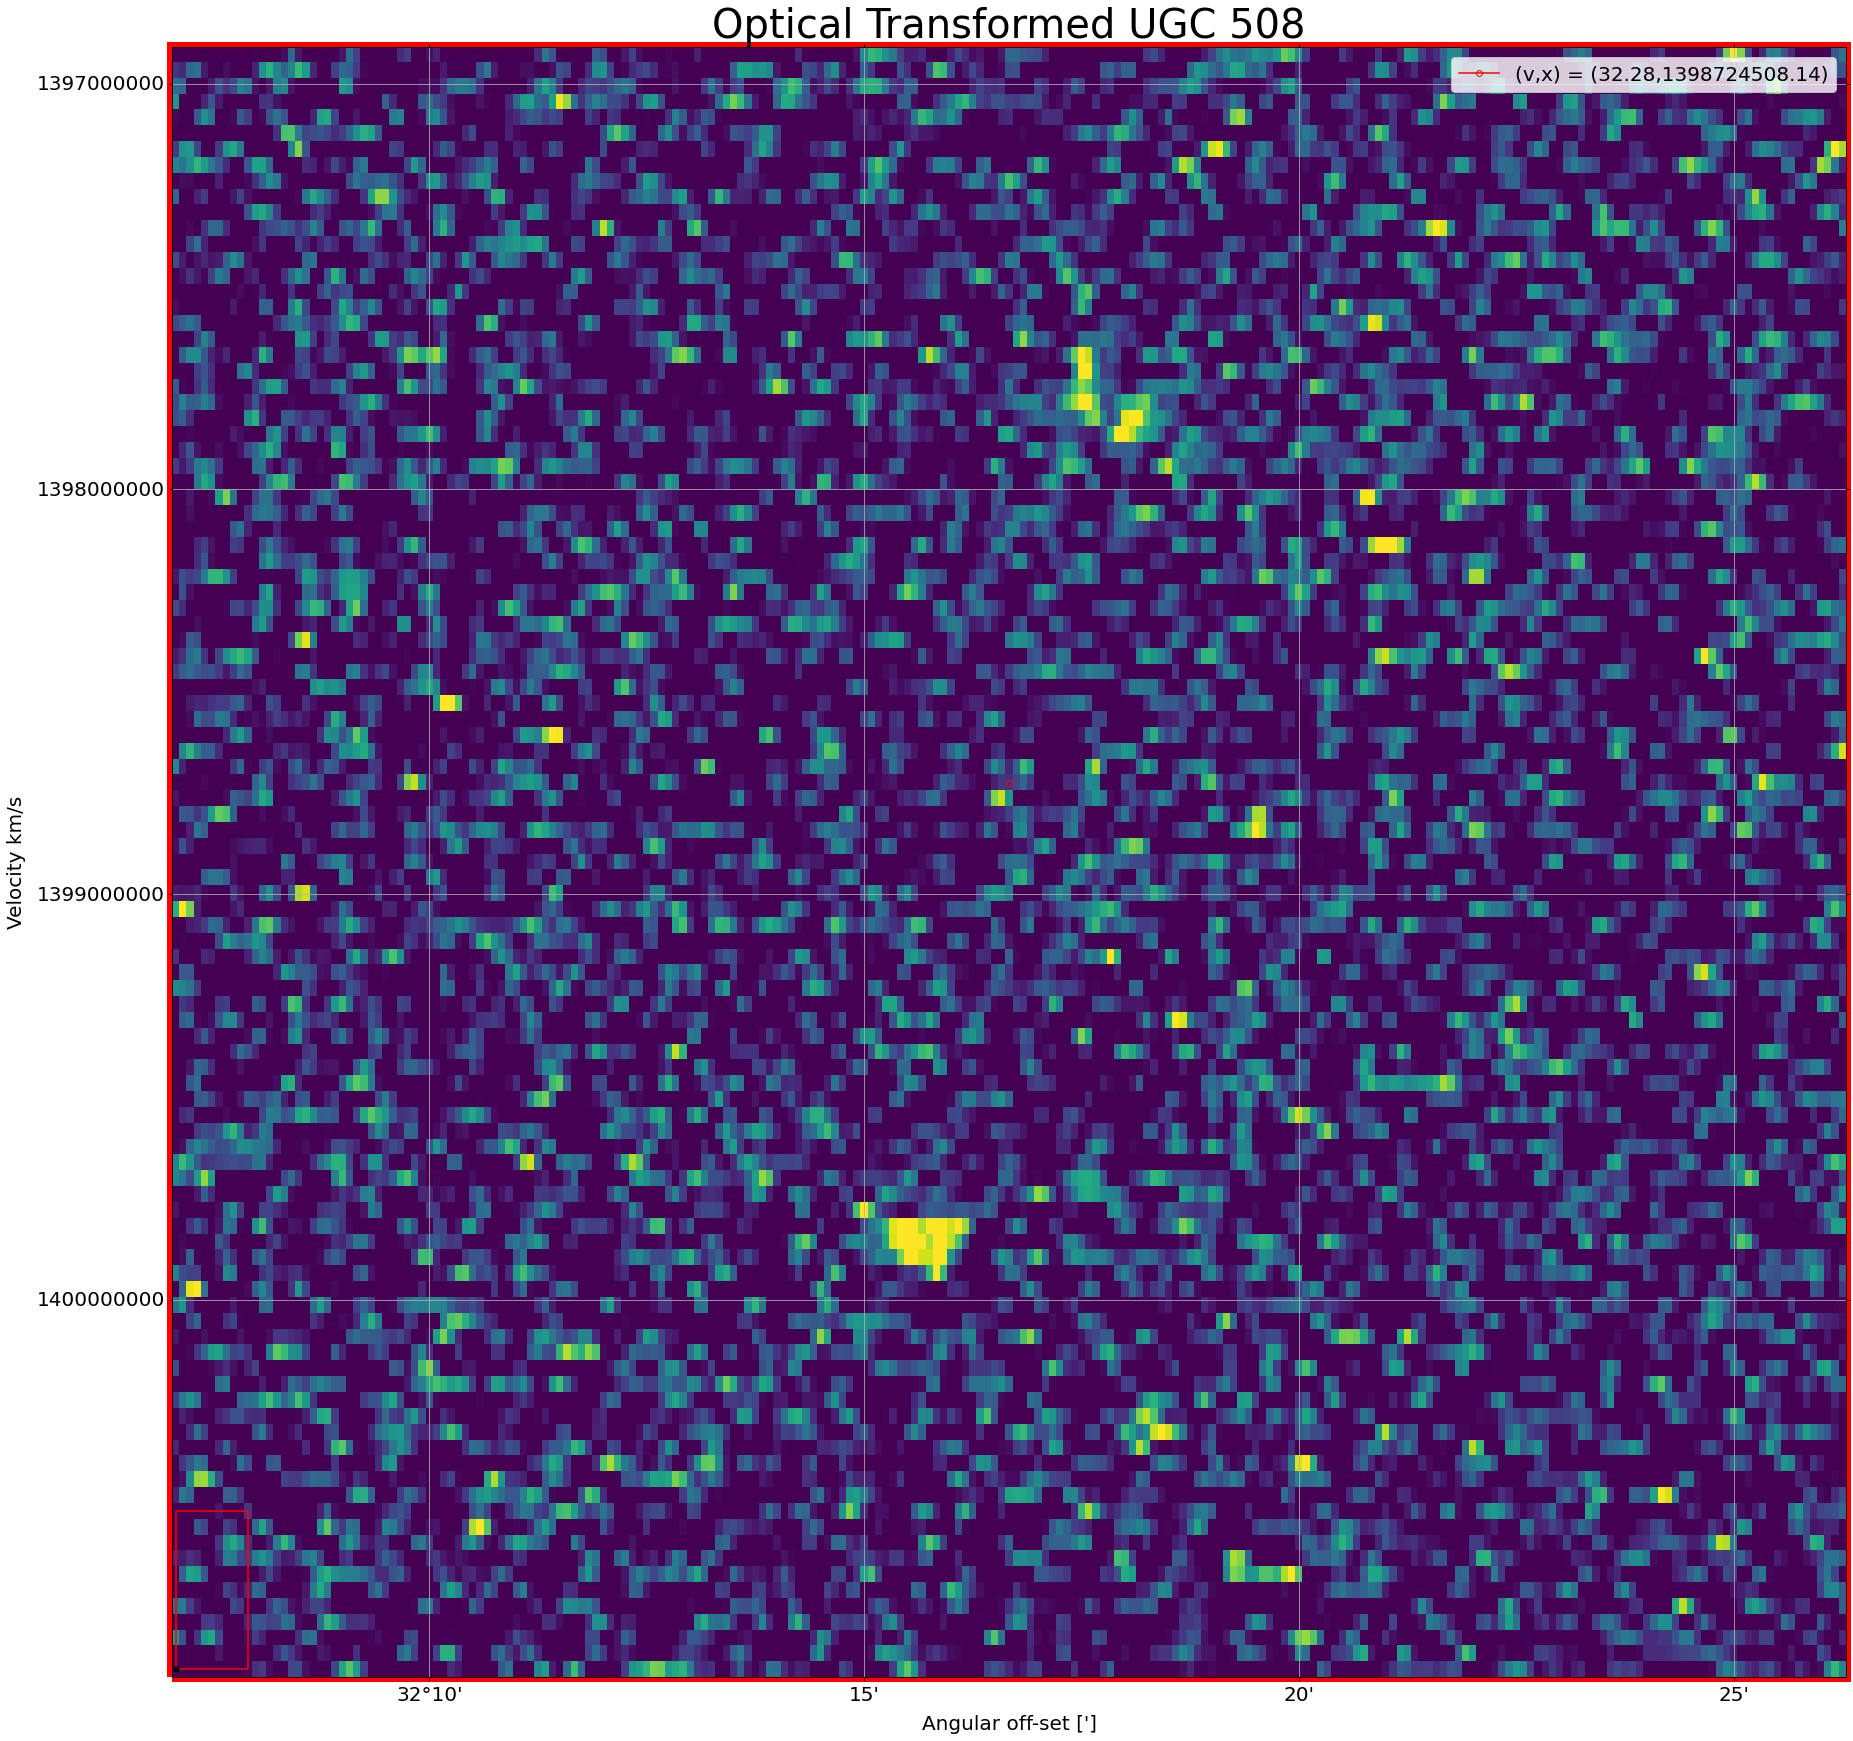

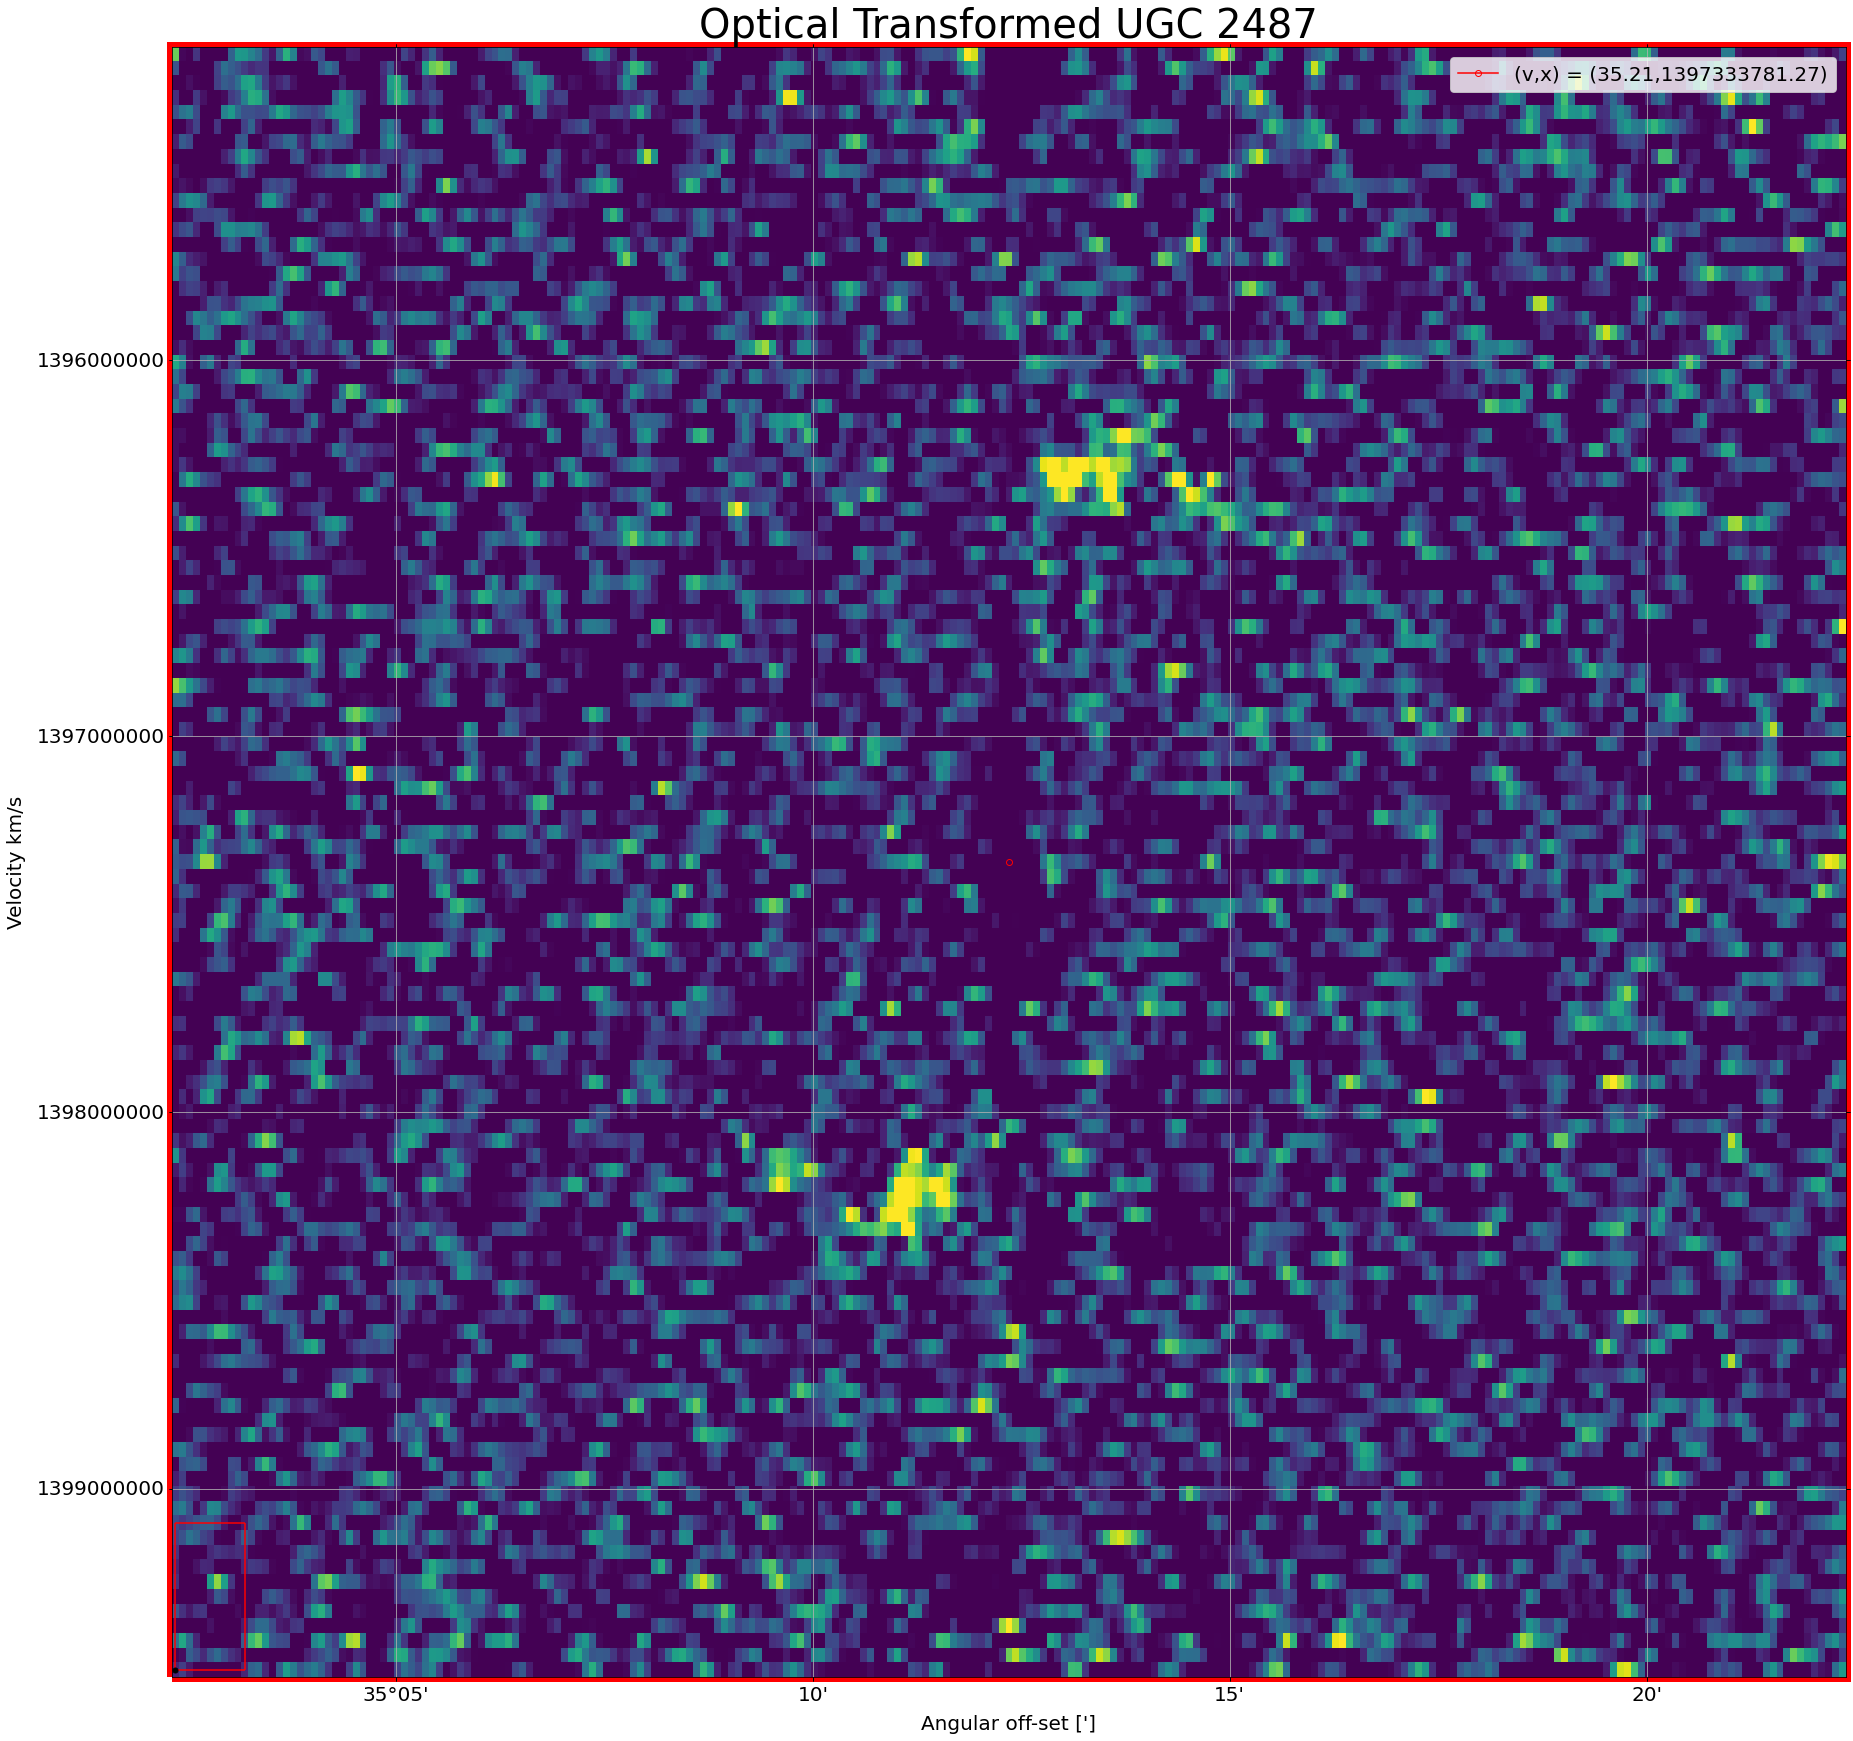

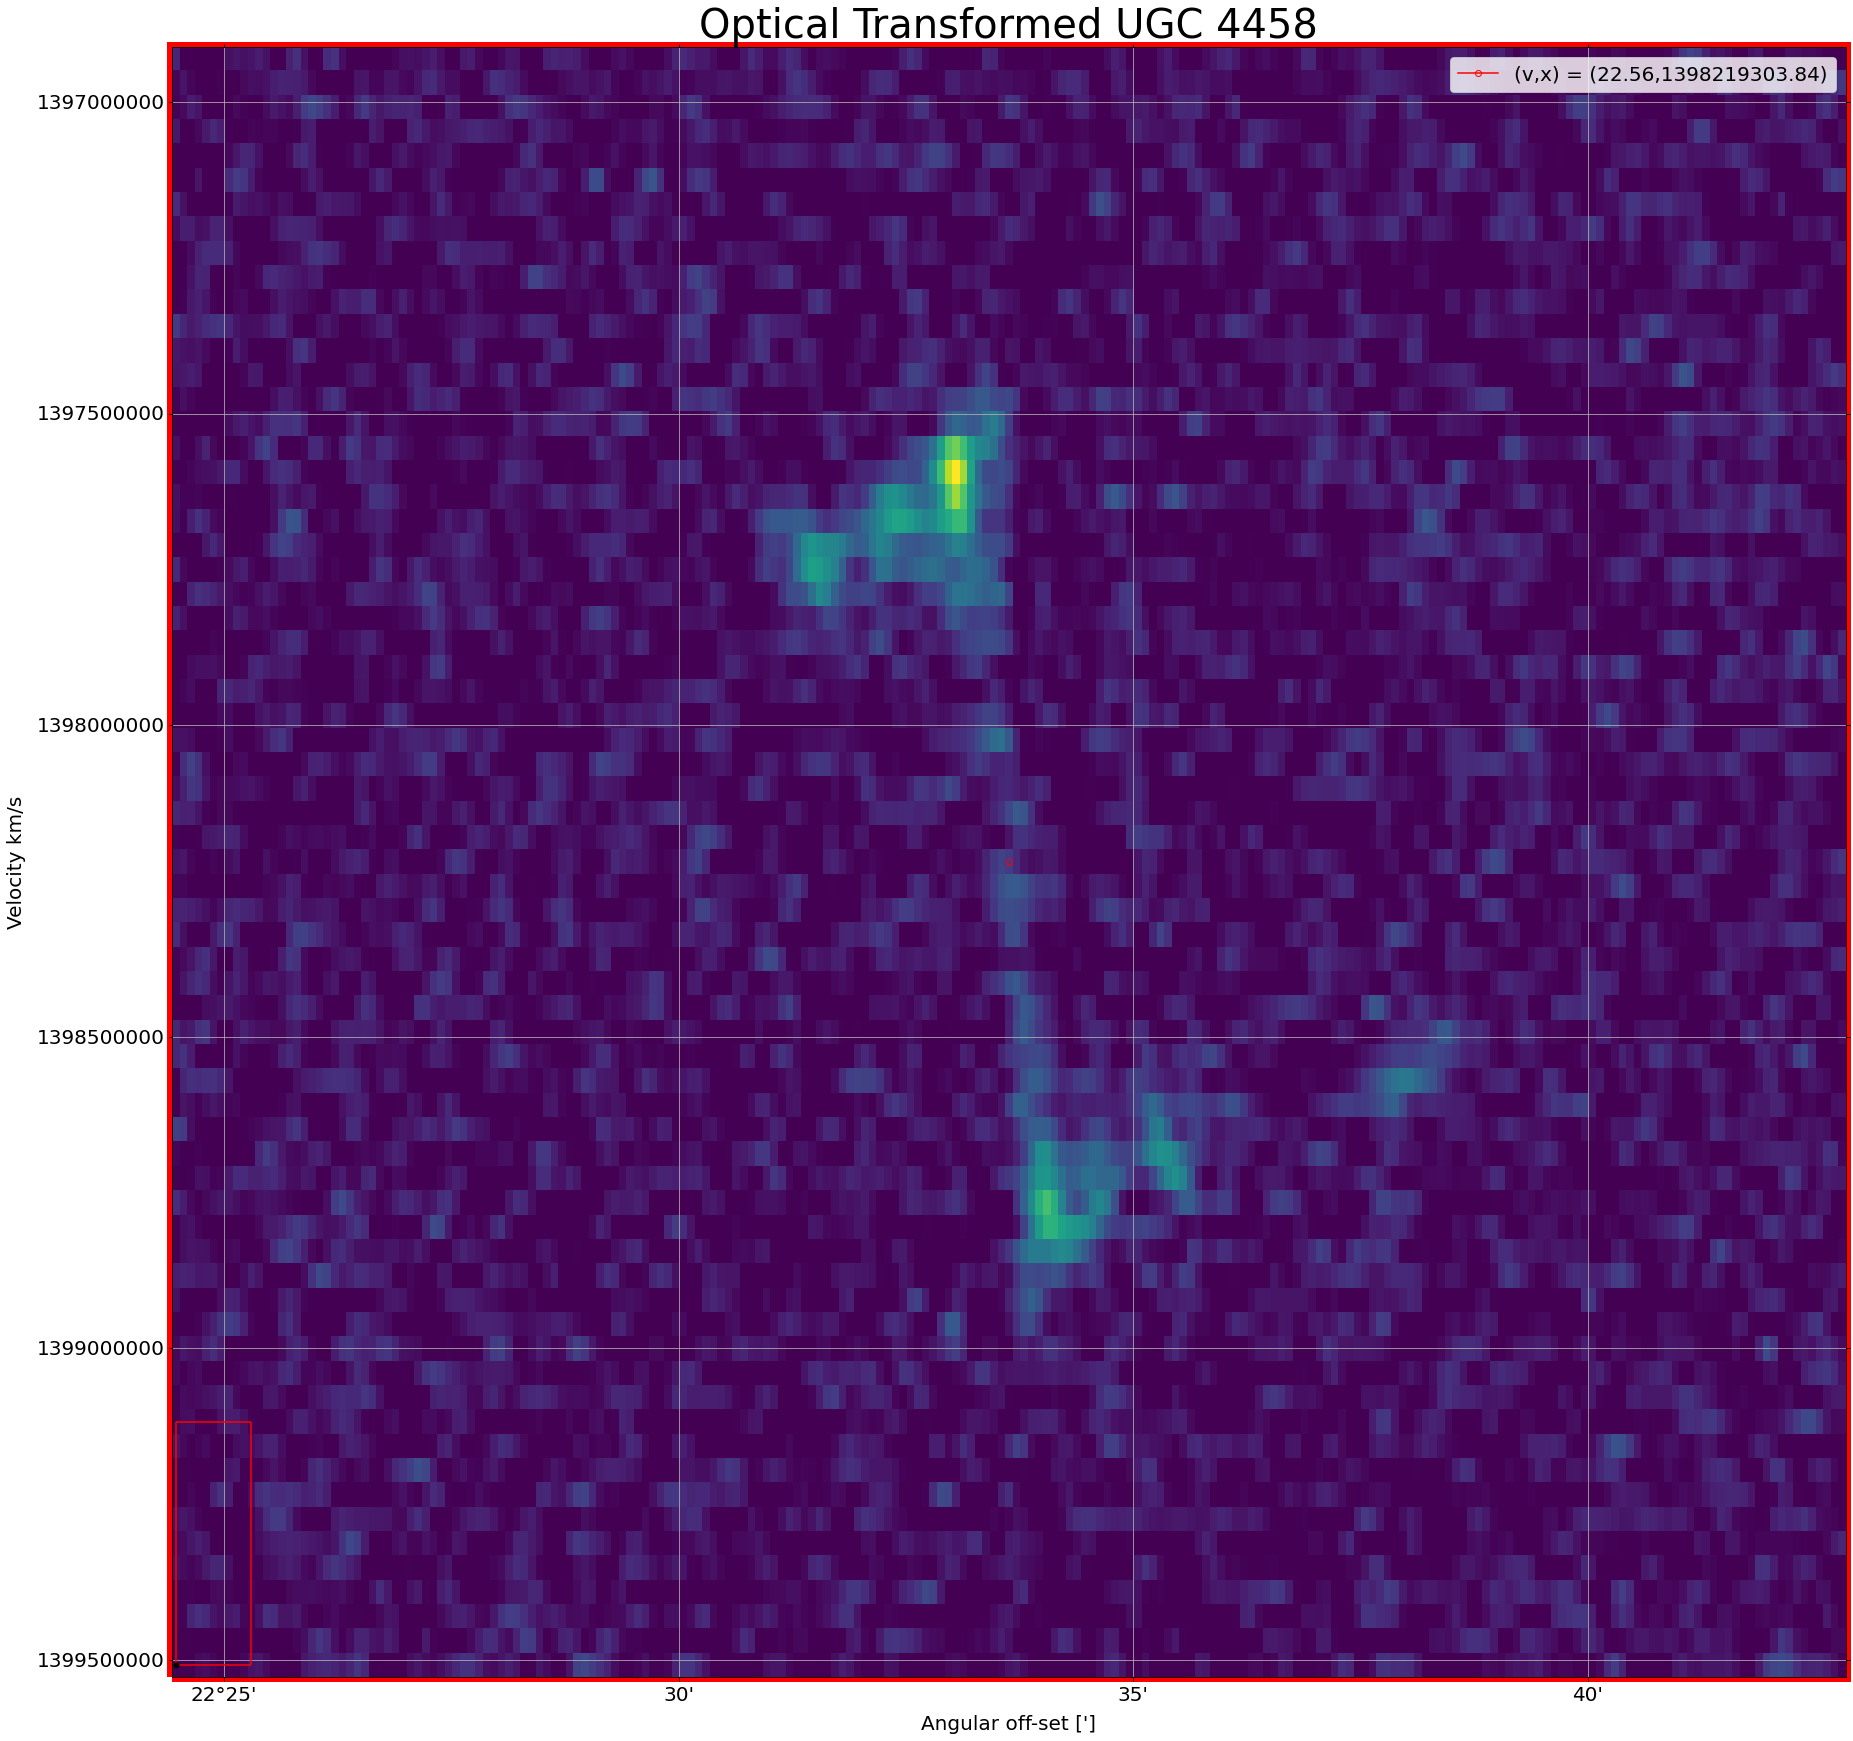

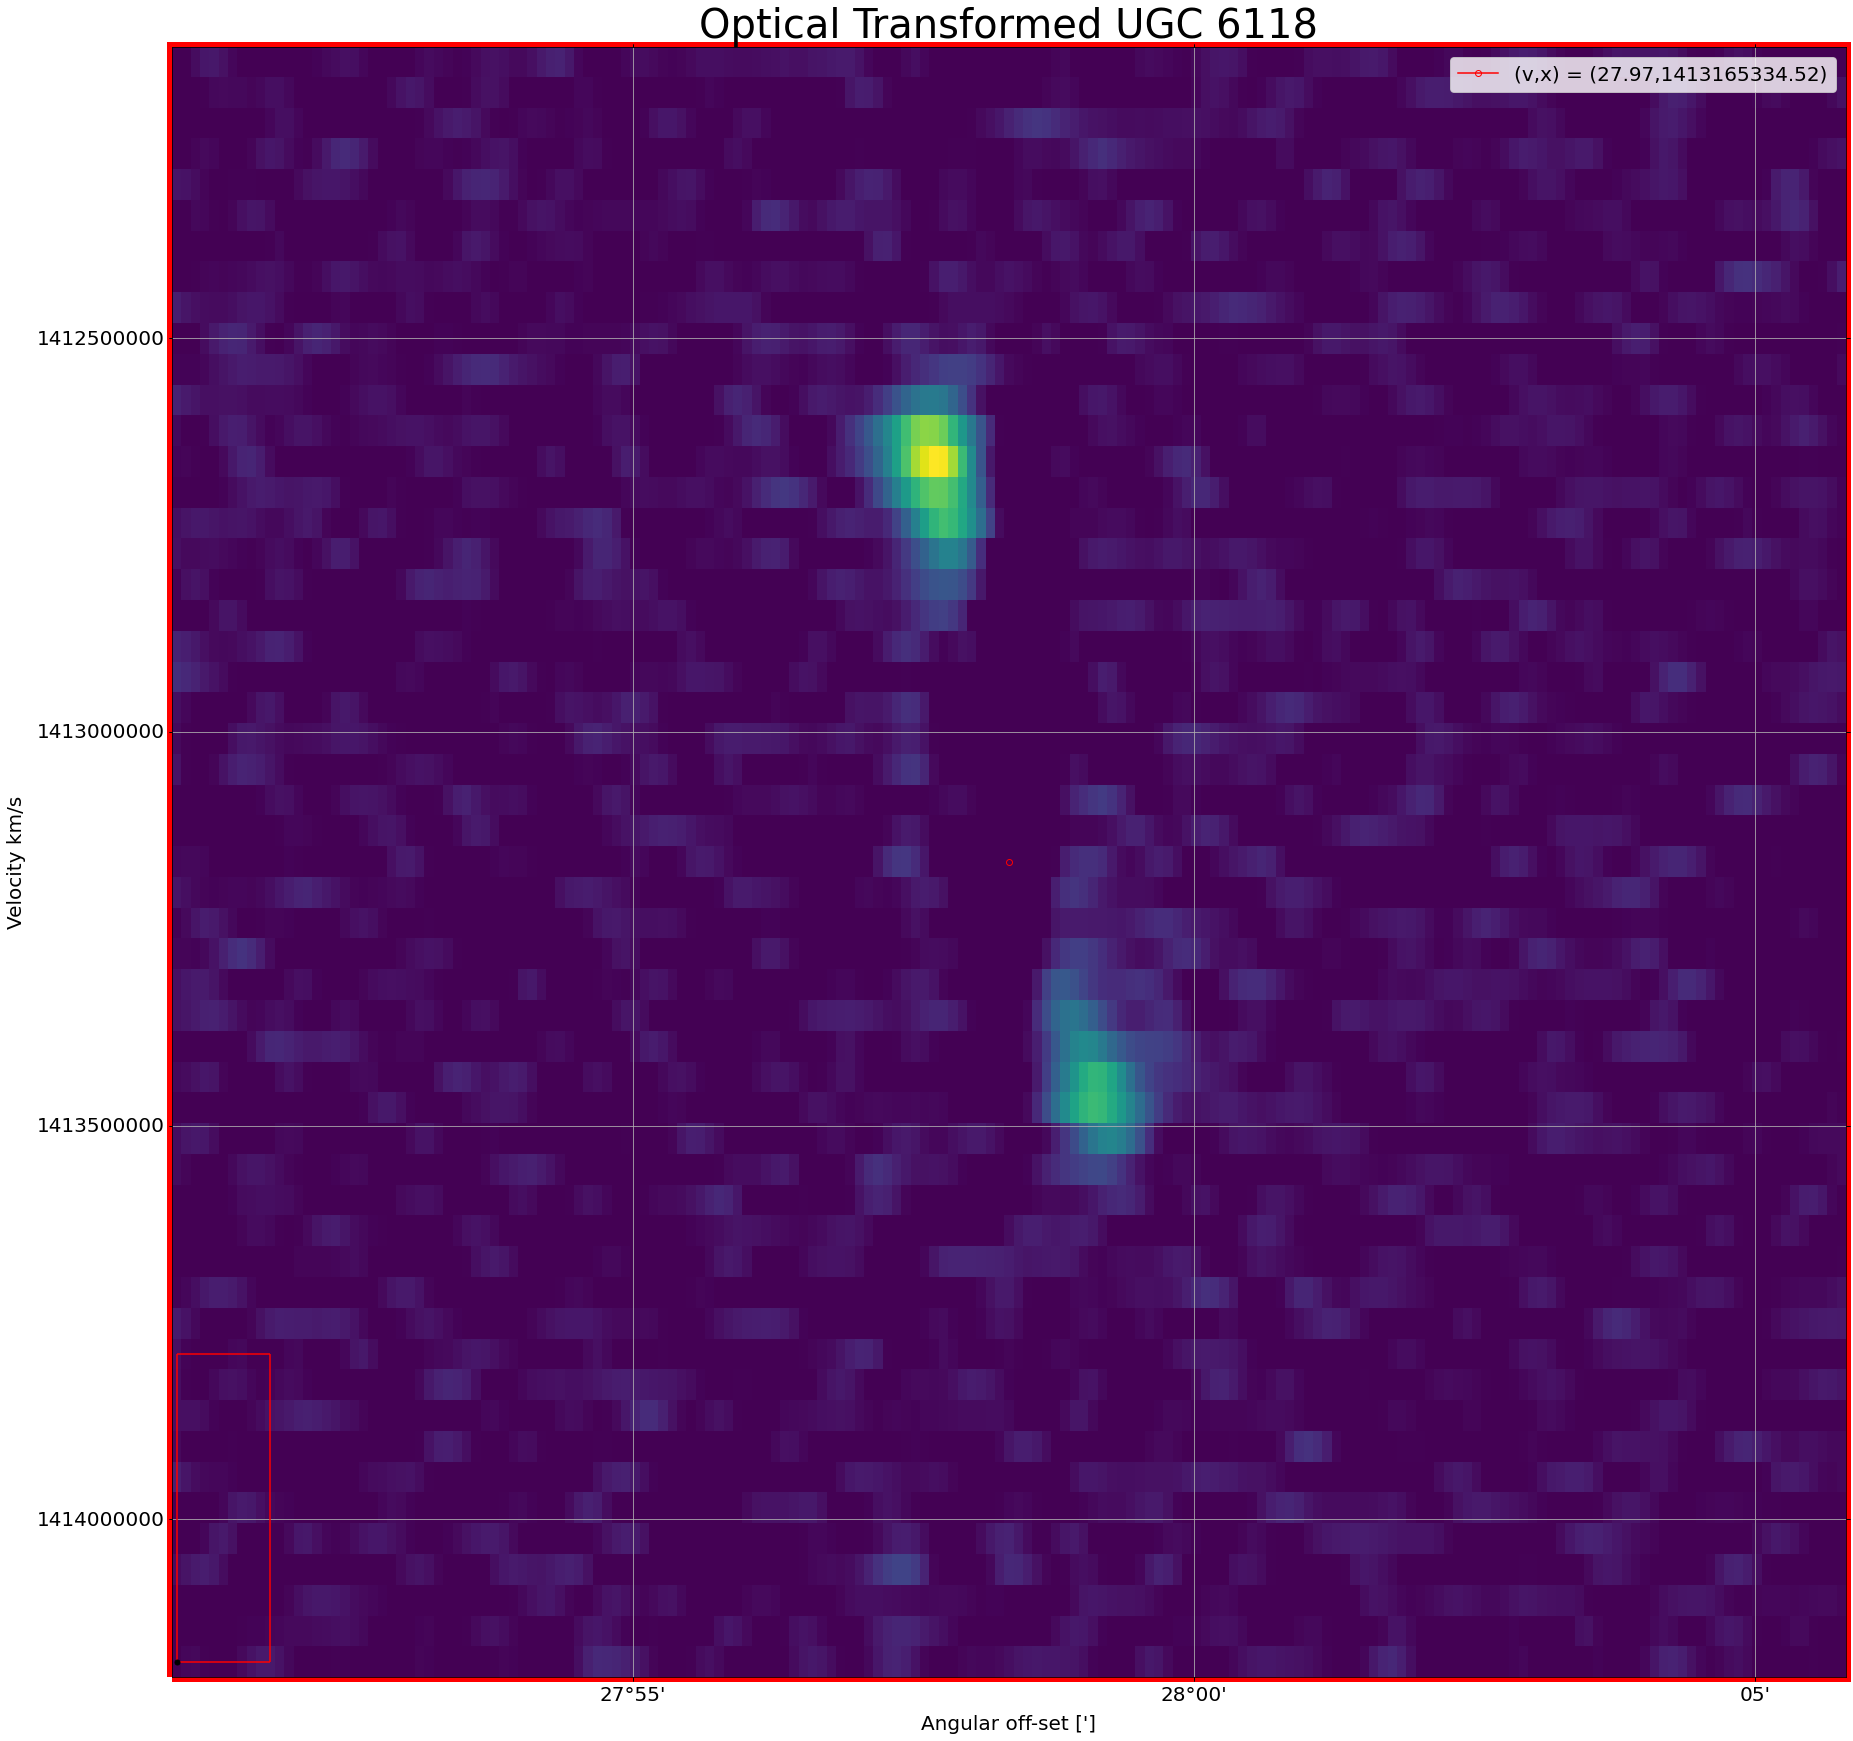

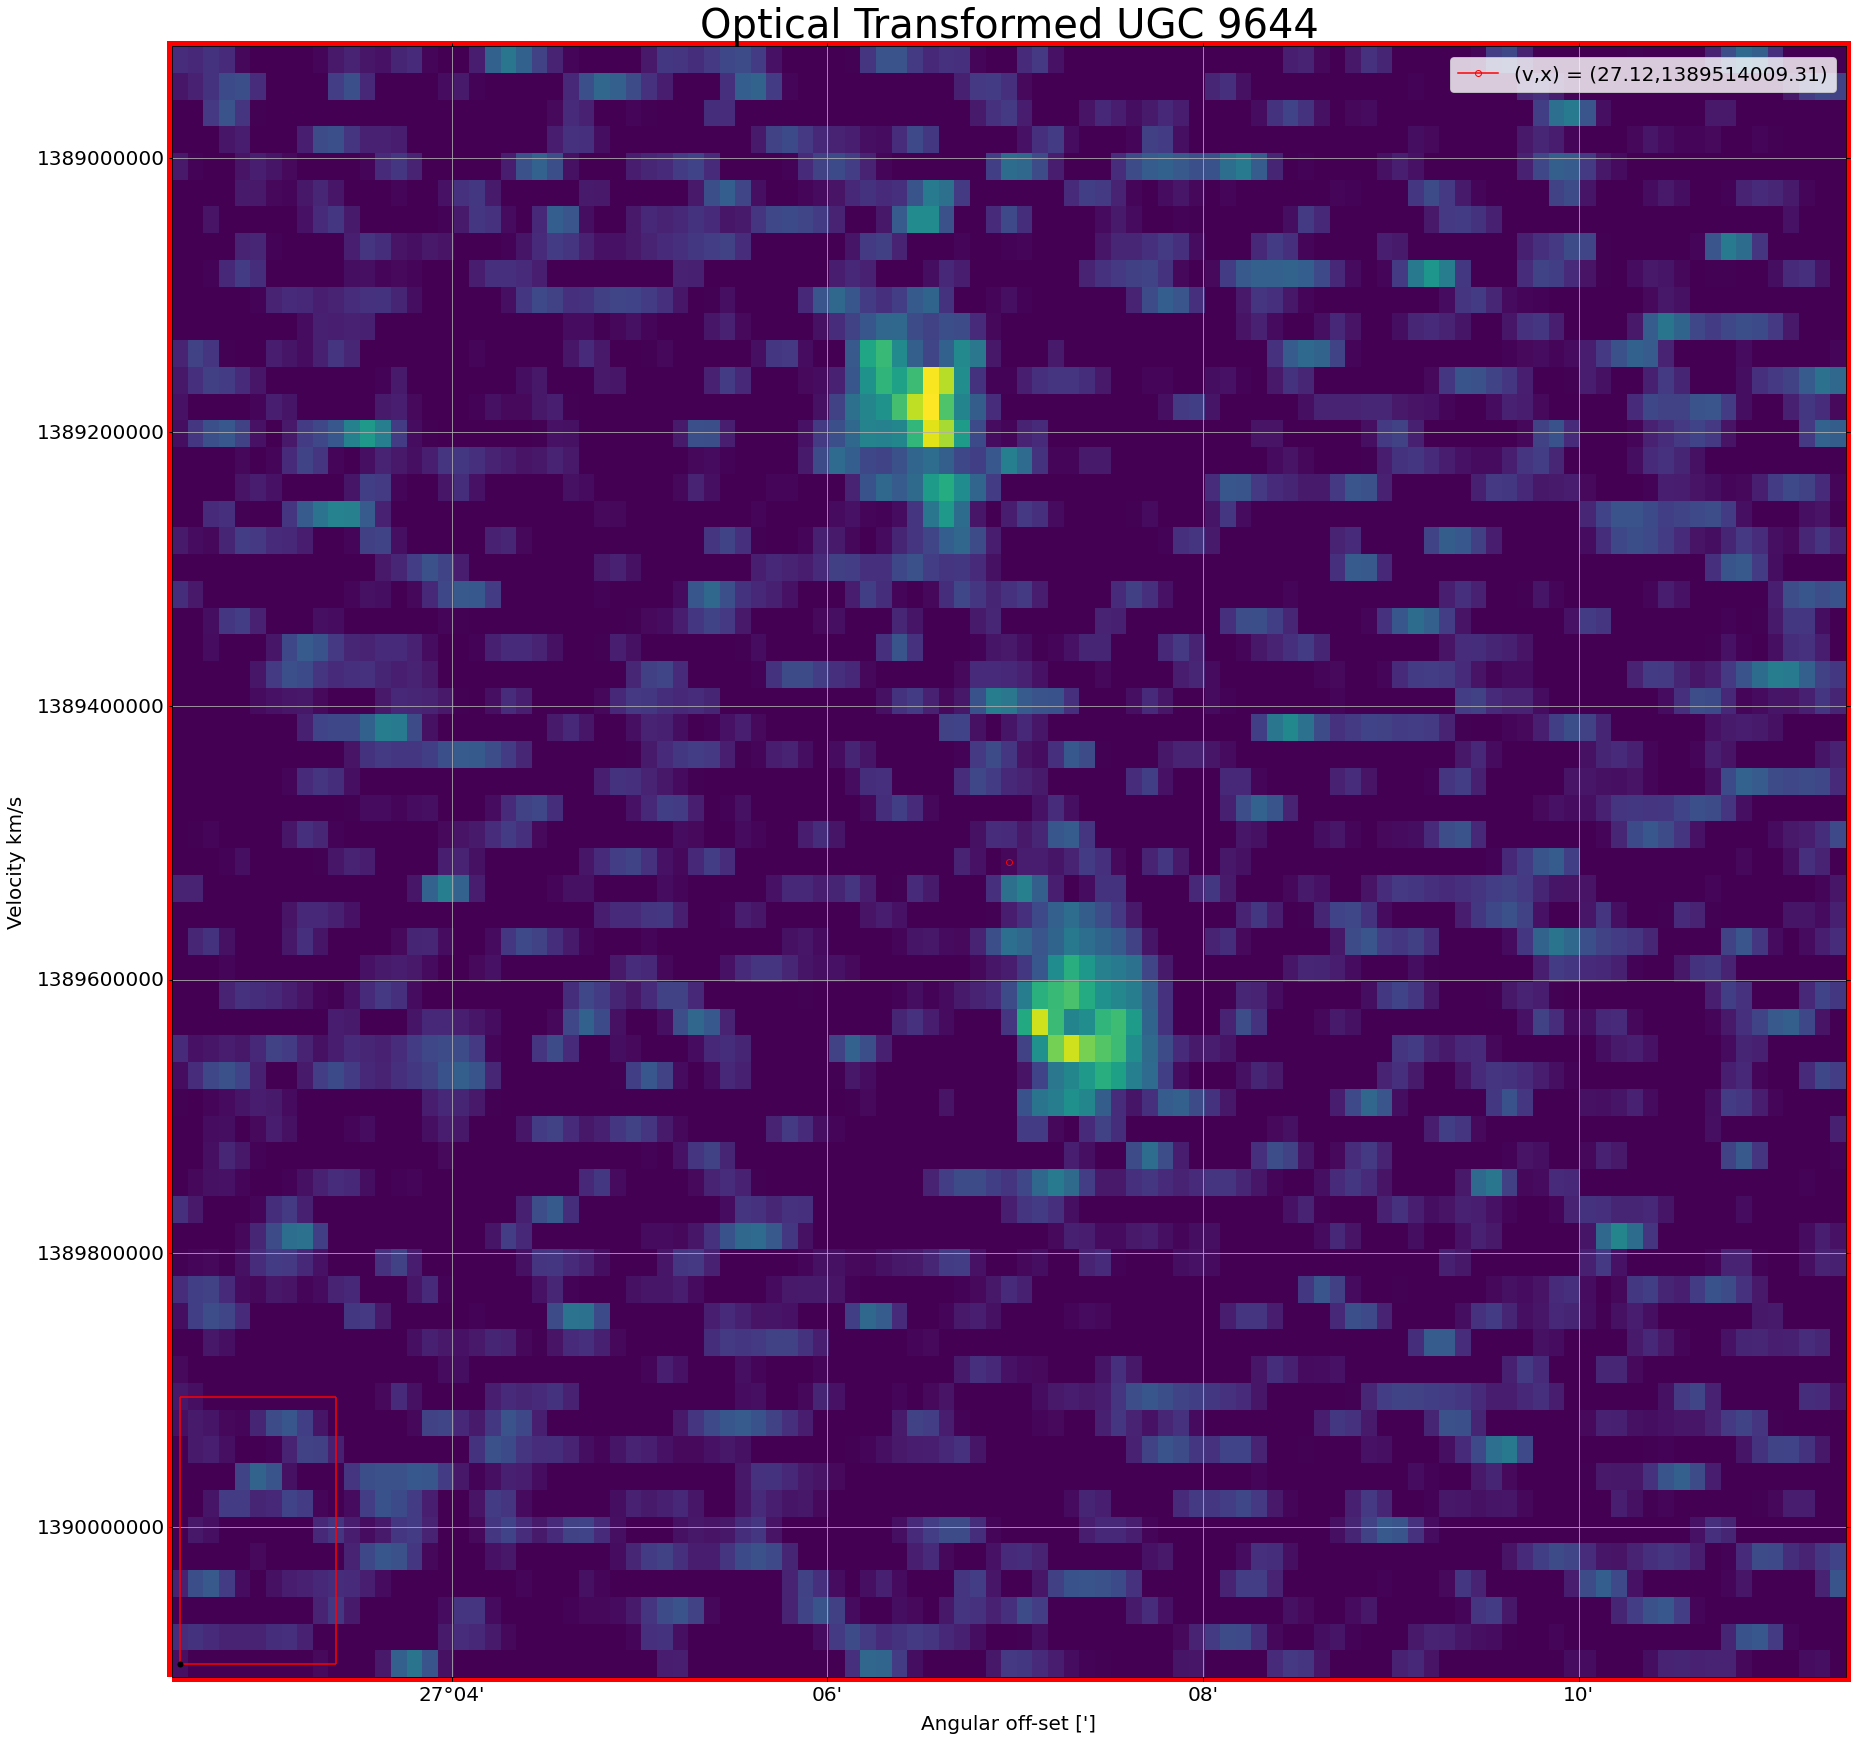

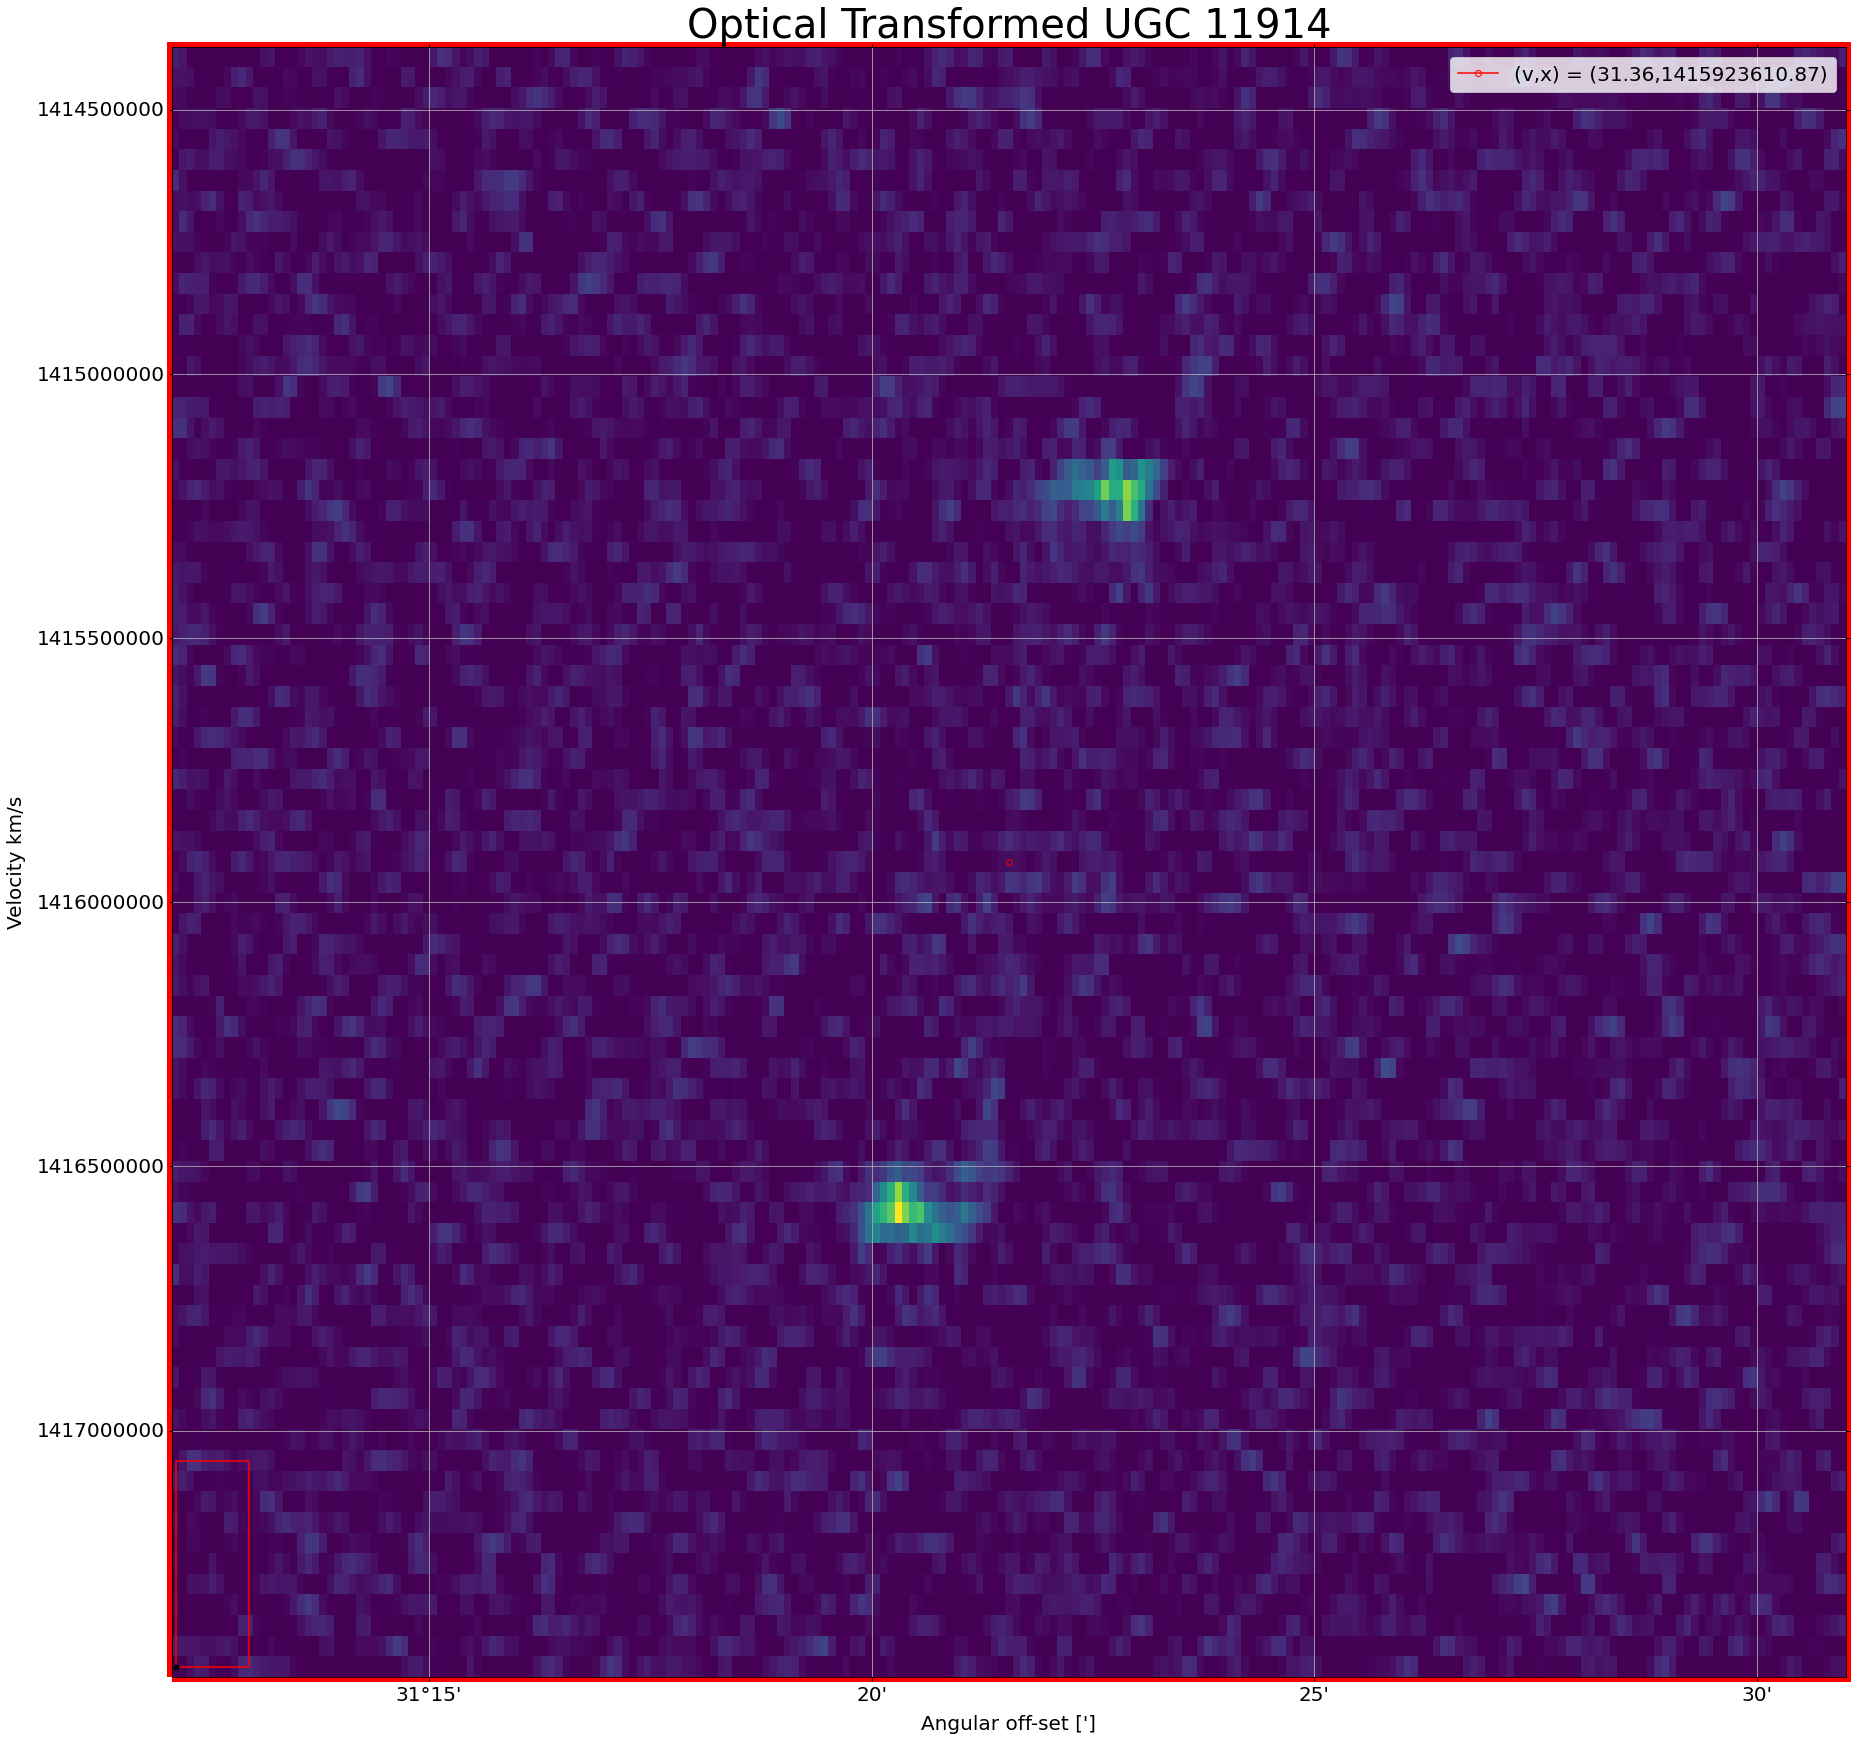

In [14]:
exclude = []
count = 0

for file in sample:
    try:
        ugcNumb = file
        filename = f'{subroot}/RNEWu/RoNEWu{str(int(ugcNumb))}cl.fits' 
        
        cube = SpectralCube.read(filename)
        f = plt.figure(figsize=(30,30))
        plotOnePV(cube,0)
        plt.legend(loc=0,fontsize = 20)
        #plt.savefig(f'/home/andrew/Desktop/spectral_registration_pvds_wrong/UGC{file}_pass1.png')
        plt.show()

        count+=1
        
    except(FileNotFoundError):
        print('Not found')
        pass

# E.) Invert Cubelets Spectrally

In [15]:
def doublefold(inputCube,outputFitsFile):
    """
    Reads in a FITS file of the name inputFitsFile, creats a spectral-cube object.
    Spectral cube object is transformed to numpy ndarray object.
    Loops through the spectral channels, flipping each frame vertically, storing it in a new array.
    Exports new fits file of array of rotated frames.
    """
    cube = inputCube
    cubeARR = np.array(cube)

    shape = np.shape(cube)
    dat = np.zeros(shape) 

    print(shape)
    
    image = UpMirror
    
    InvertedImage = np.fliplr(UpMirror)
    dat = InvertedImage    
    return(dat)

def invertCube(inputFitsFile,outputFitsFile):
    """
    Reads in a FITS file of the name inputFitsFile, creats a spectral-cube object.
    Spectral cube object is transformed to numpy ndarray object.
    Loops through the spectral channels, flipping each frame vertically, storing it in a new array.
    Exports new fits file of array of rotated frames.
    """
    cube = SpectralCube.read(inputFitsFile)
    cubeARR = np.array(cube)

    shape = np.shape(cube)
    dat = np.zeros(shape) 

    print(shape)
    for i in range((shape[0])):
        image = cubeARR[i,:,:]
        InvertedImage = np.flipud(image)                           #AUTOMATE??
        dat[i] = InvertedImage

    invCube = SpectralCube(dat,wcs= cube.wcs)    
    invCube.write(outputFitsFile,overwrite = True, format='fits')
    invCube = fits.open(outputFitsFile)
    header = invCube[0].header
    invCube_shape = invCube[0].shape
    

    header['CTYPE3'] = 'FREQ'
    header['CUNIT3'] = 'Hz'
    invCube.writeto(outputFitsFile,overwrite=True)

    update_header(inputFitsFile,outputFitsFile,beam_copy=True)
    inverted_cube = SpectralCube.read(outputFitsFile)
    return(inverted_cube)

In [16]:
invert = UGC[(PA['Rotational_direction']==0)].tolist()#Update this list with those galaxies NOT spinning in fiducial direction
exclude  = []                                         #Update this list with problematic data cubes
for ugcNumb in sample: 
    filename = f'{subroot}/RNEWu/RoNEWu{str(int(ugcNumb))}cl.fits' 
    out_name = f'{subroot}/IRNEWu/IRoNEWu{str(int(ugcNumb))}cl.fits'
    if ugcNumb in invert:
        print(ugcNumb,'rotating')
        try:
            cube = invertCube(filename,out_name)
            
        except (FileNotFoundError):
            pass    
    else:
        print(ugcNumb,'retaining')
        try:
            cube = SpectralCube.read(filename)
            cube.write(out_name,overwrite = True, format='fits')
        
        except(FileNotFoundError):
            print('oops')
            pass 

508 retaining
2487 retaining
4458 rotating


(67, 221, 221)
6118 rotating


(53, 179, 179)
9644 rotating


(61, 107, 107)
11914 retaining


In [53]:
cube1 = SpectralCube.read(f'{drive}/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/RNEWu/RoNEWu9644cl.fits')
cube2 = SpectralCube.read(f'{drive}/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu9644cl.fits')
hdr1 = cube1.header
hdr2 = cube2.header
print('stage','shape','centre','crpix')
print(' RNEW',cube1.shape,get_centre(cube1,fits_cen=False),[hdr1[f'CRPIX{i}']-1 for i in [1,2,3]])
print('IRNEW',cube2.shape,get_centre(cube2,fits_cen=False),[hdr2[f'CRPIX{i}']-1 for i in [1,2,3]])

stage shape centre crpix
 RNEW (61, 107, 107) [53. 53. 30.] [53.0, 53.0, 30.0]
IRNEW (61, 107, 107) [53. 53. 30.] [53.0, 53.0, 30.0]


# F.) Append Zero-Points and PA etc to Header

In [17]:
count = 0
ra_2000   = PA['RA [J2000]']
dec_2000  = PA['DEC [J2000]']
ra_1950   = PA['RA [B1950]']
dec_1950  = PA['DEC [B1950]']

for ugcNumb in sample:
    file = ugcNumb
    filename = f'{subroot}/IRNEWu/IRoNEWu{int(ugcNumb)}cl.fits'
    OutputFilename = f'{subroot}/UIRNEWu/UIRoNEWu{int(ugcNumb)}cl.fits'
    try:
        print(filename)
        index = np.where(PA.UGC == ugcNumb)[0][0]
        print(index)
        beam_ra = BEAM_RA[int(index)]
        beam_dec = BEAM_DEC[int(index)]
        beam_v = BEAM_V[int(index)]
        cube = fits.open(filename)
        spec_cube = SpectralCube.read(filename)
        hdr = spec_cube.header
        xcen,ycen,vcen = get_centre(spec_cube,True)
        header = cube[0].header   
        
        

        hdr['CTYPE3'] = 'FREQ'
        hdr['CUNIT3'] = 'Hz'

        hdr['REST_VEL'] = freq2vel(hdr['FREQ0']*u.Hz).value

        cube.writeto(OutputFilename,overwrite=True)
        cube.close()
        update_header(filename,OutputFilename,beam_copy= True)
        count+=1
        
        if count == 2:
            count-=1
            
    except(ValueError):
        print()
        pass  

/home/andy/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu508cl.fits
4
/home/andy/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu2487cl.fits
13
/home/andy/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu4458cl.fits
27
/home/andy/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu6118cl.fits
39
/home/andy/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu9644cl.fits
57
/home/andy/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu11914cl.fits
62


In [55]:
cube1 = SpectralCube.read(f'{drive}/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/IRNEWu/IRoNEWu9644cl.fits')
cube2 = SpectralCube.read(f'{drive}/Desktop/Masters2020/RotationCurves/CubeStacker/Pass1/UIRNEWu/UIRoNEWu9644cl.fits')
hdr1 = cube1.header
hdr2 = cube2.header
print('stage','shape','centre','crpix')
print(' IRNEW',cube1.shape,get_centre(cube1,fits_cen=False),[hdr1[f'CRPIX{i}']-1 for i in [1,2,3]])
print('UIRNEW',cube2.shape,get_centre(cube2,fits_cen=False),[hdr2[f'CRPIX{i}']-1 for i in [1,2,3]])

stage shape centre crpix
 IRNEW (61, 107, 107) [53. 53. 30.] [53.0, 53.0, 30.0]
UIRNEW (61, 107, 107) [53. 53. 30.] [53.0, 53.0, 30.0]


# E.)Assesing PVDs

### Creating Major-Axis PVd

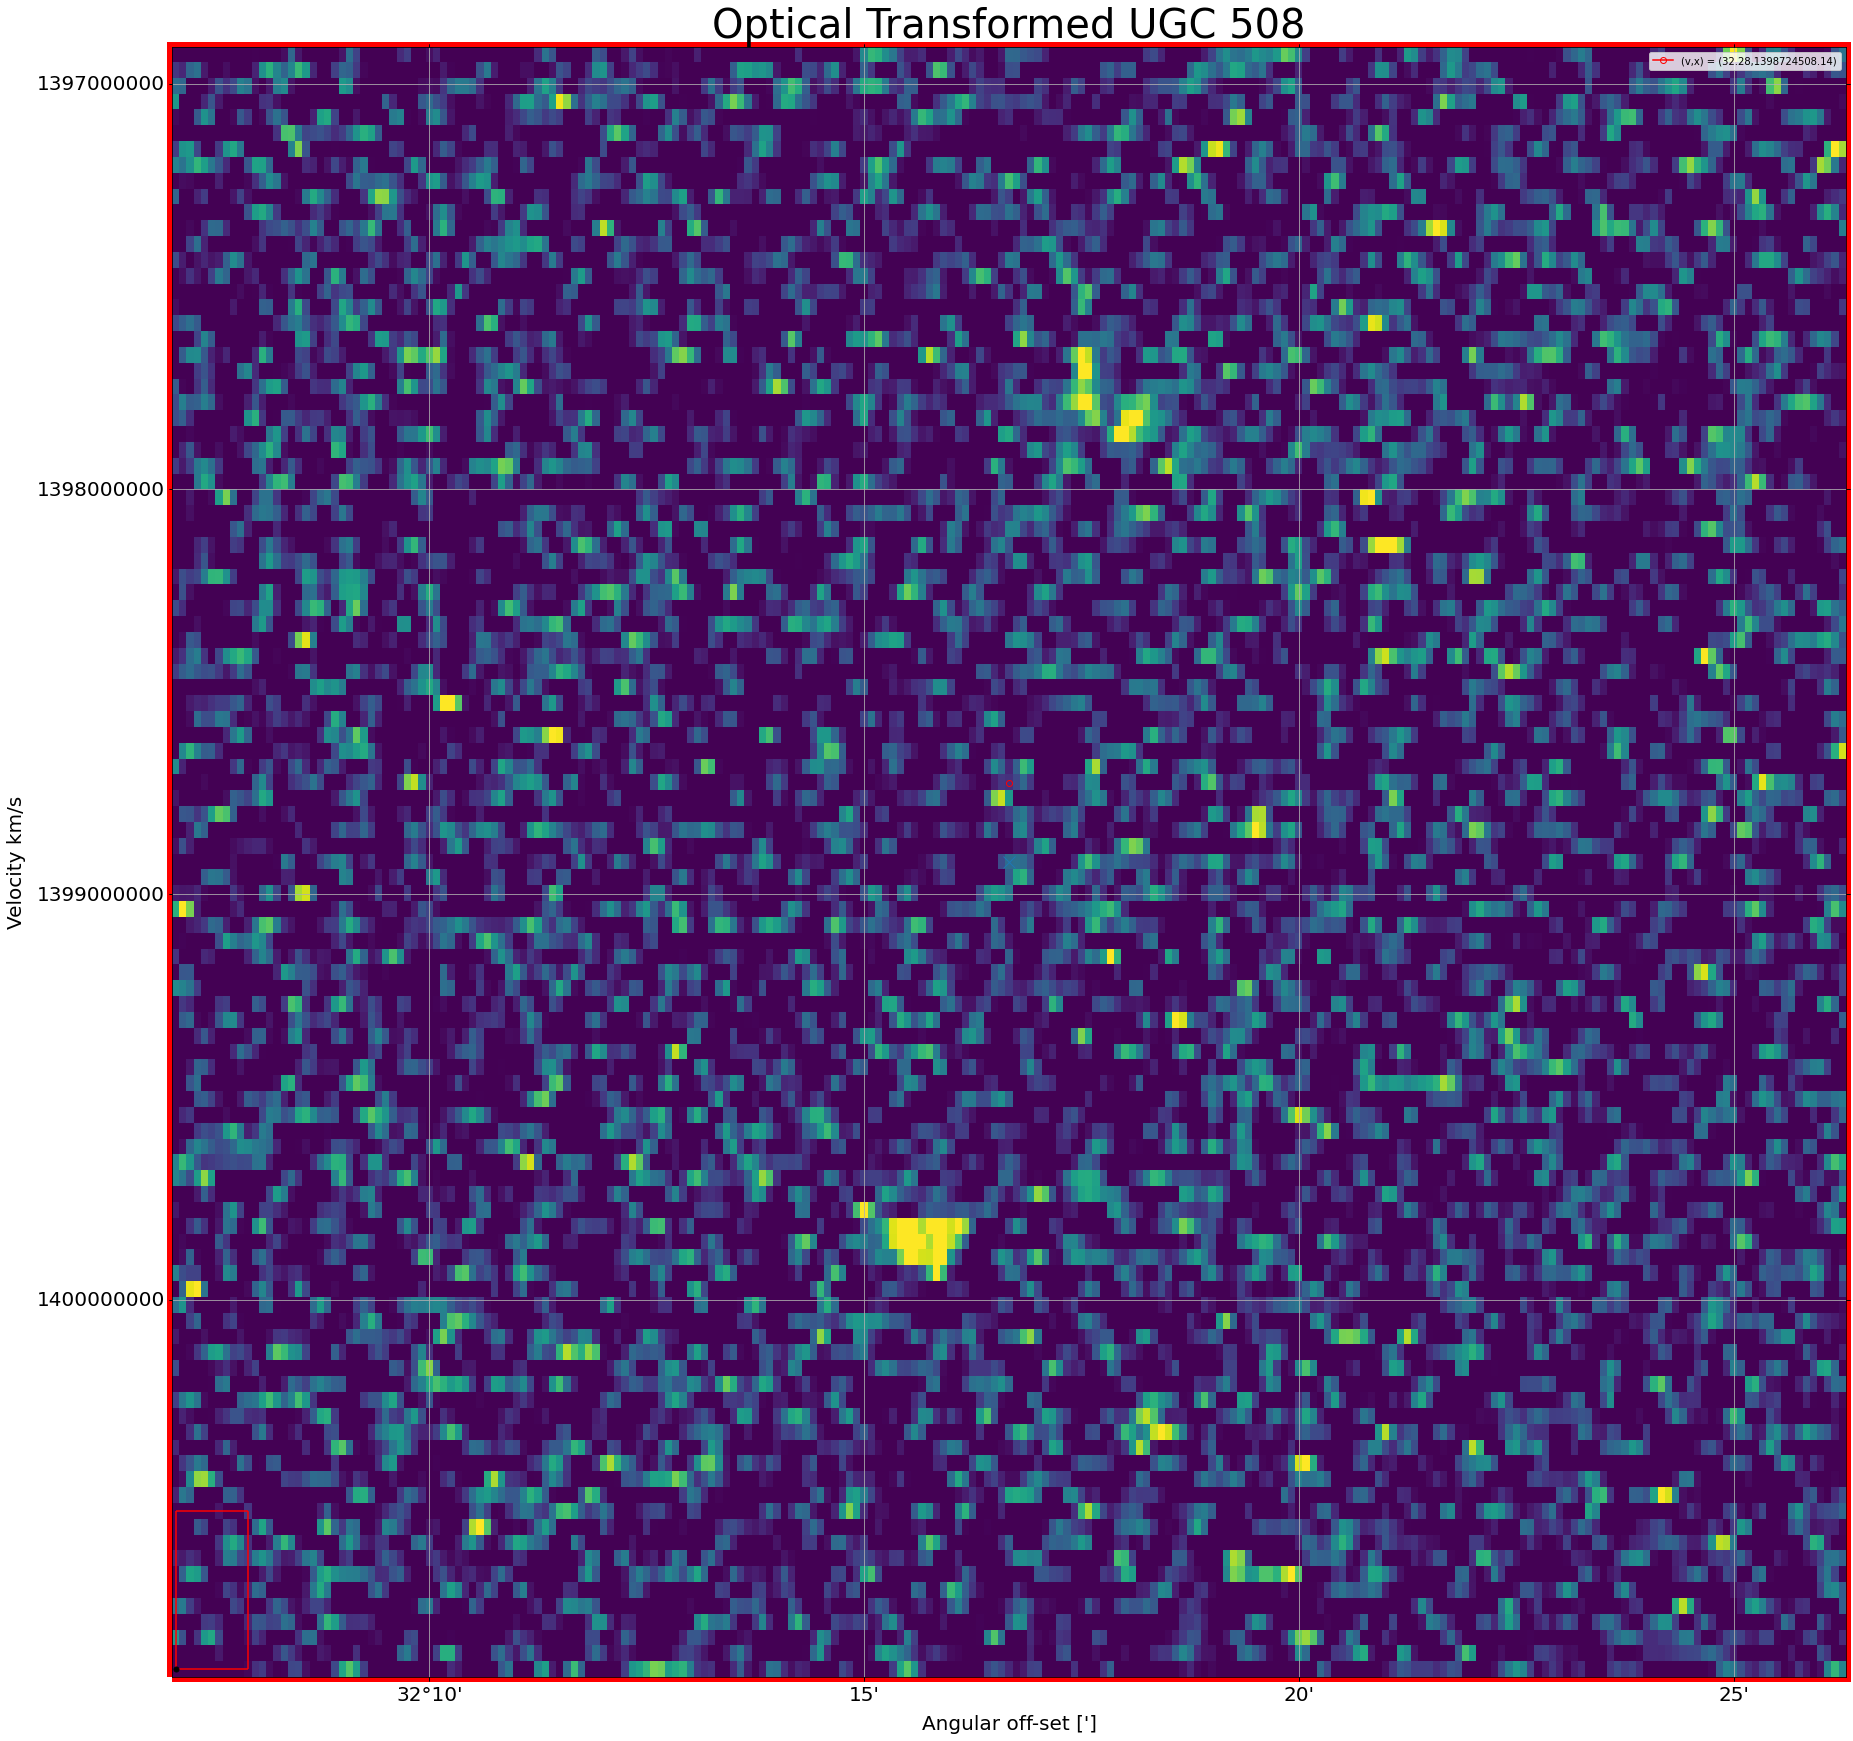

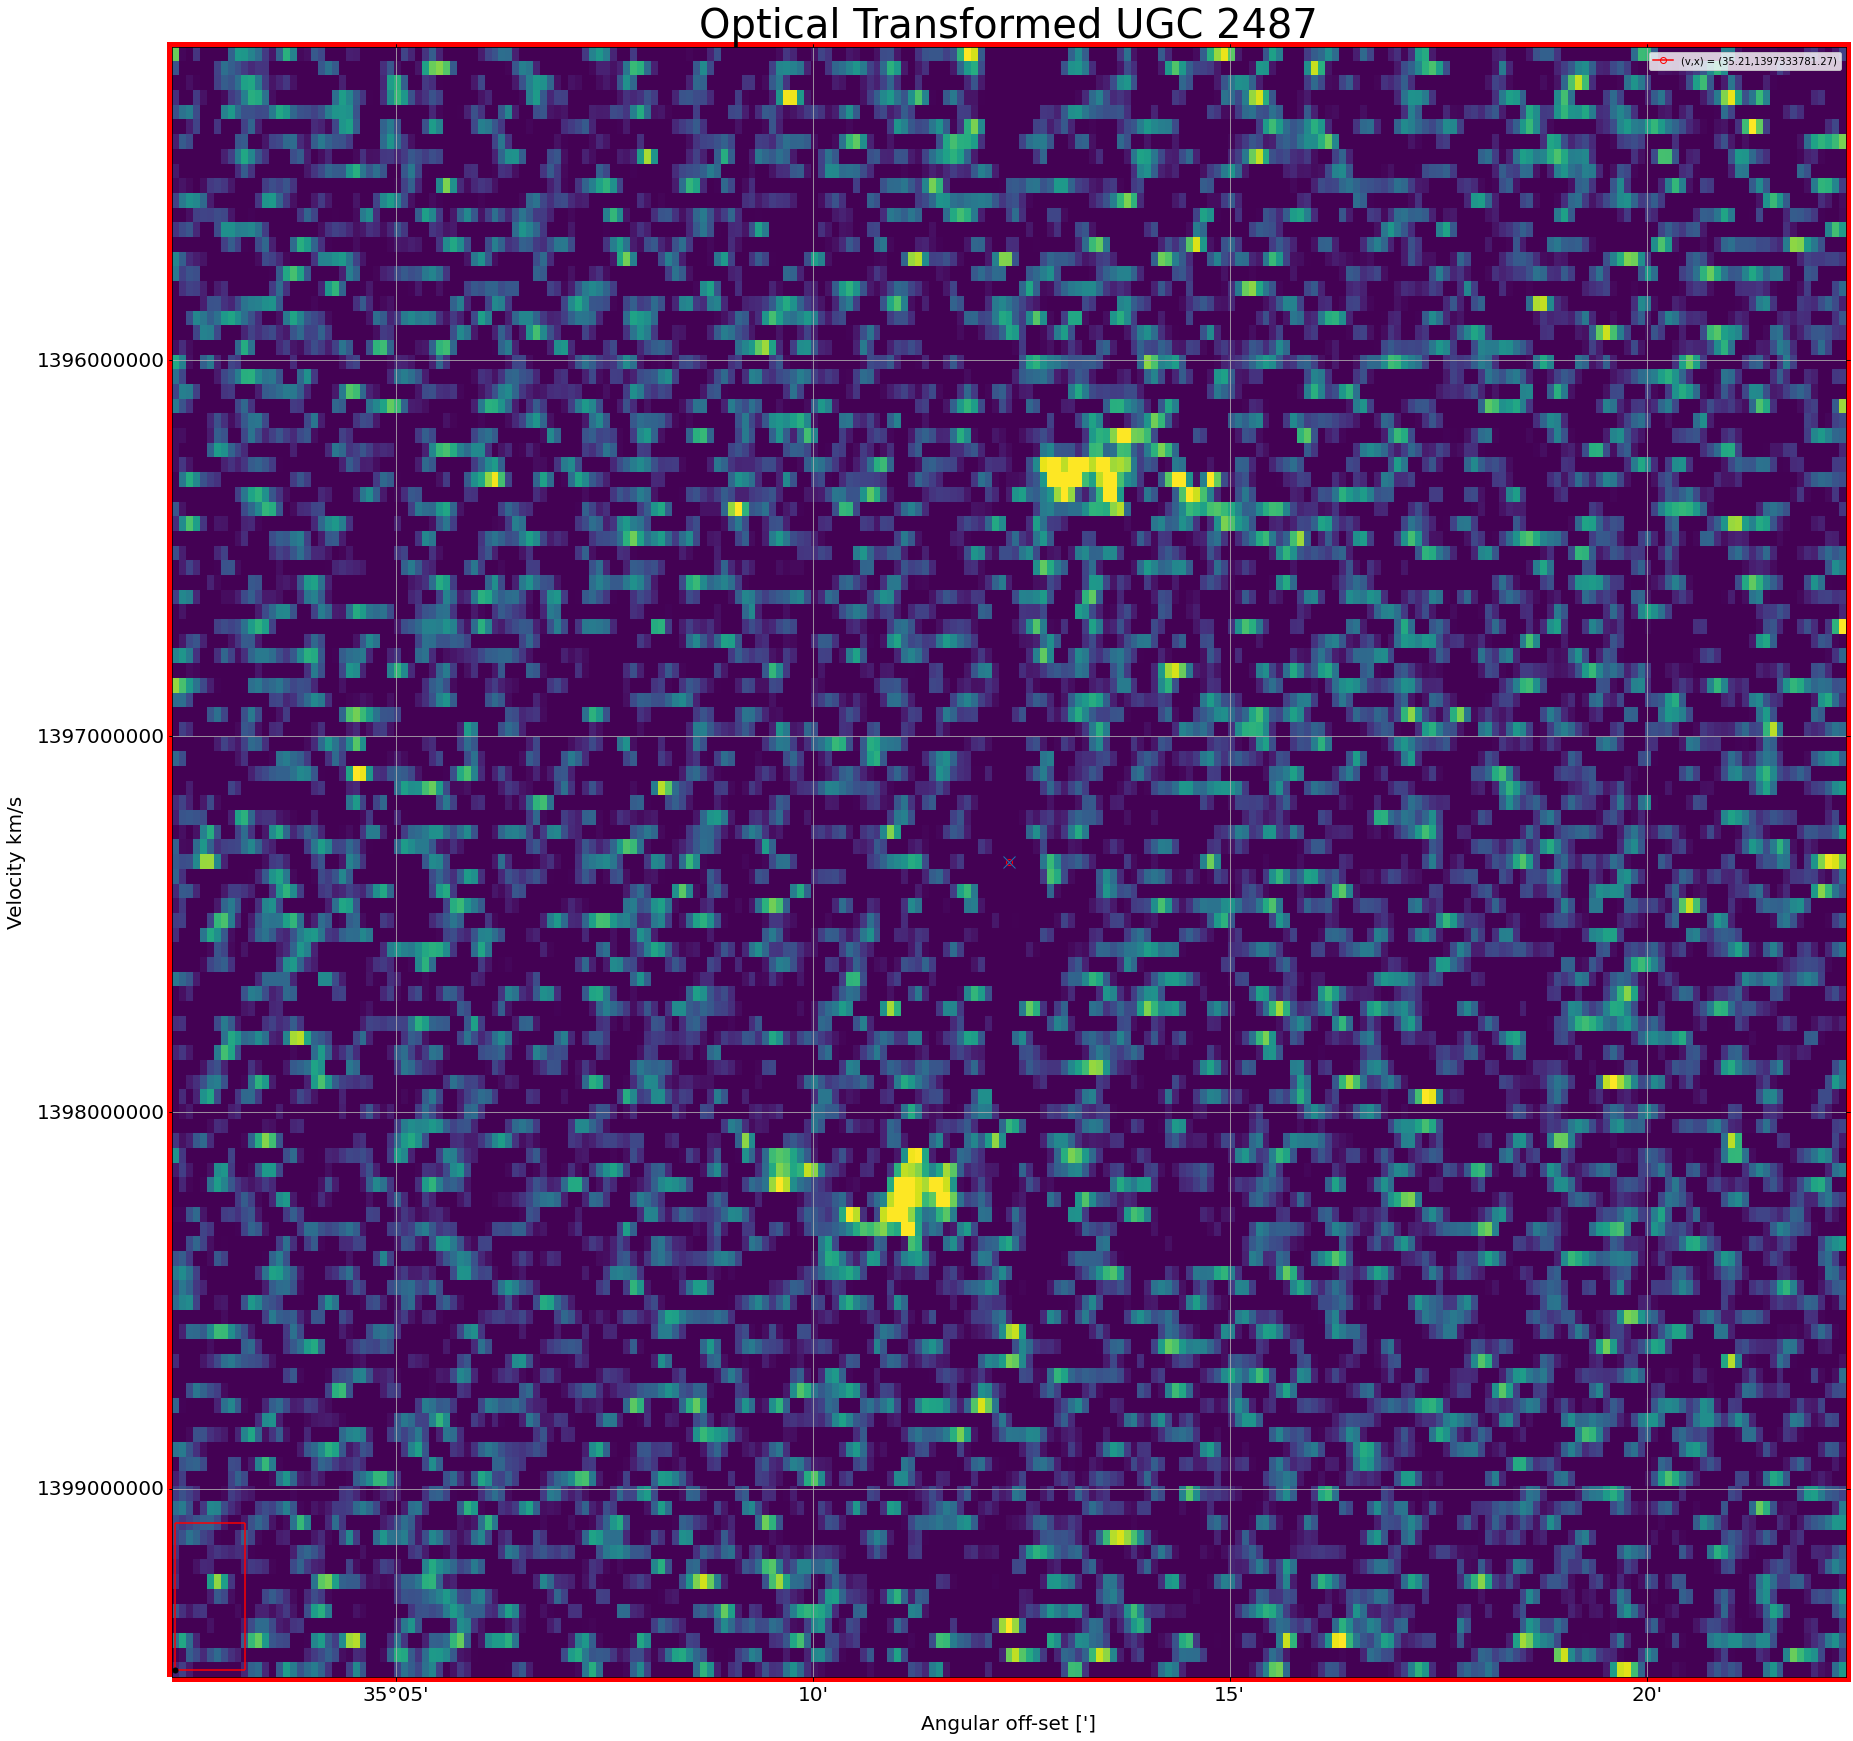

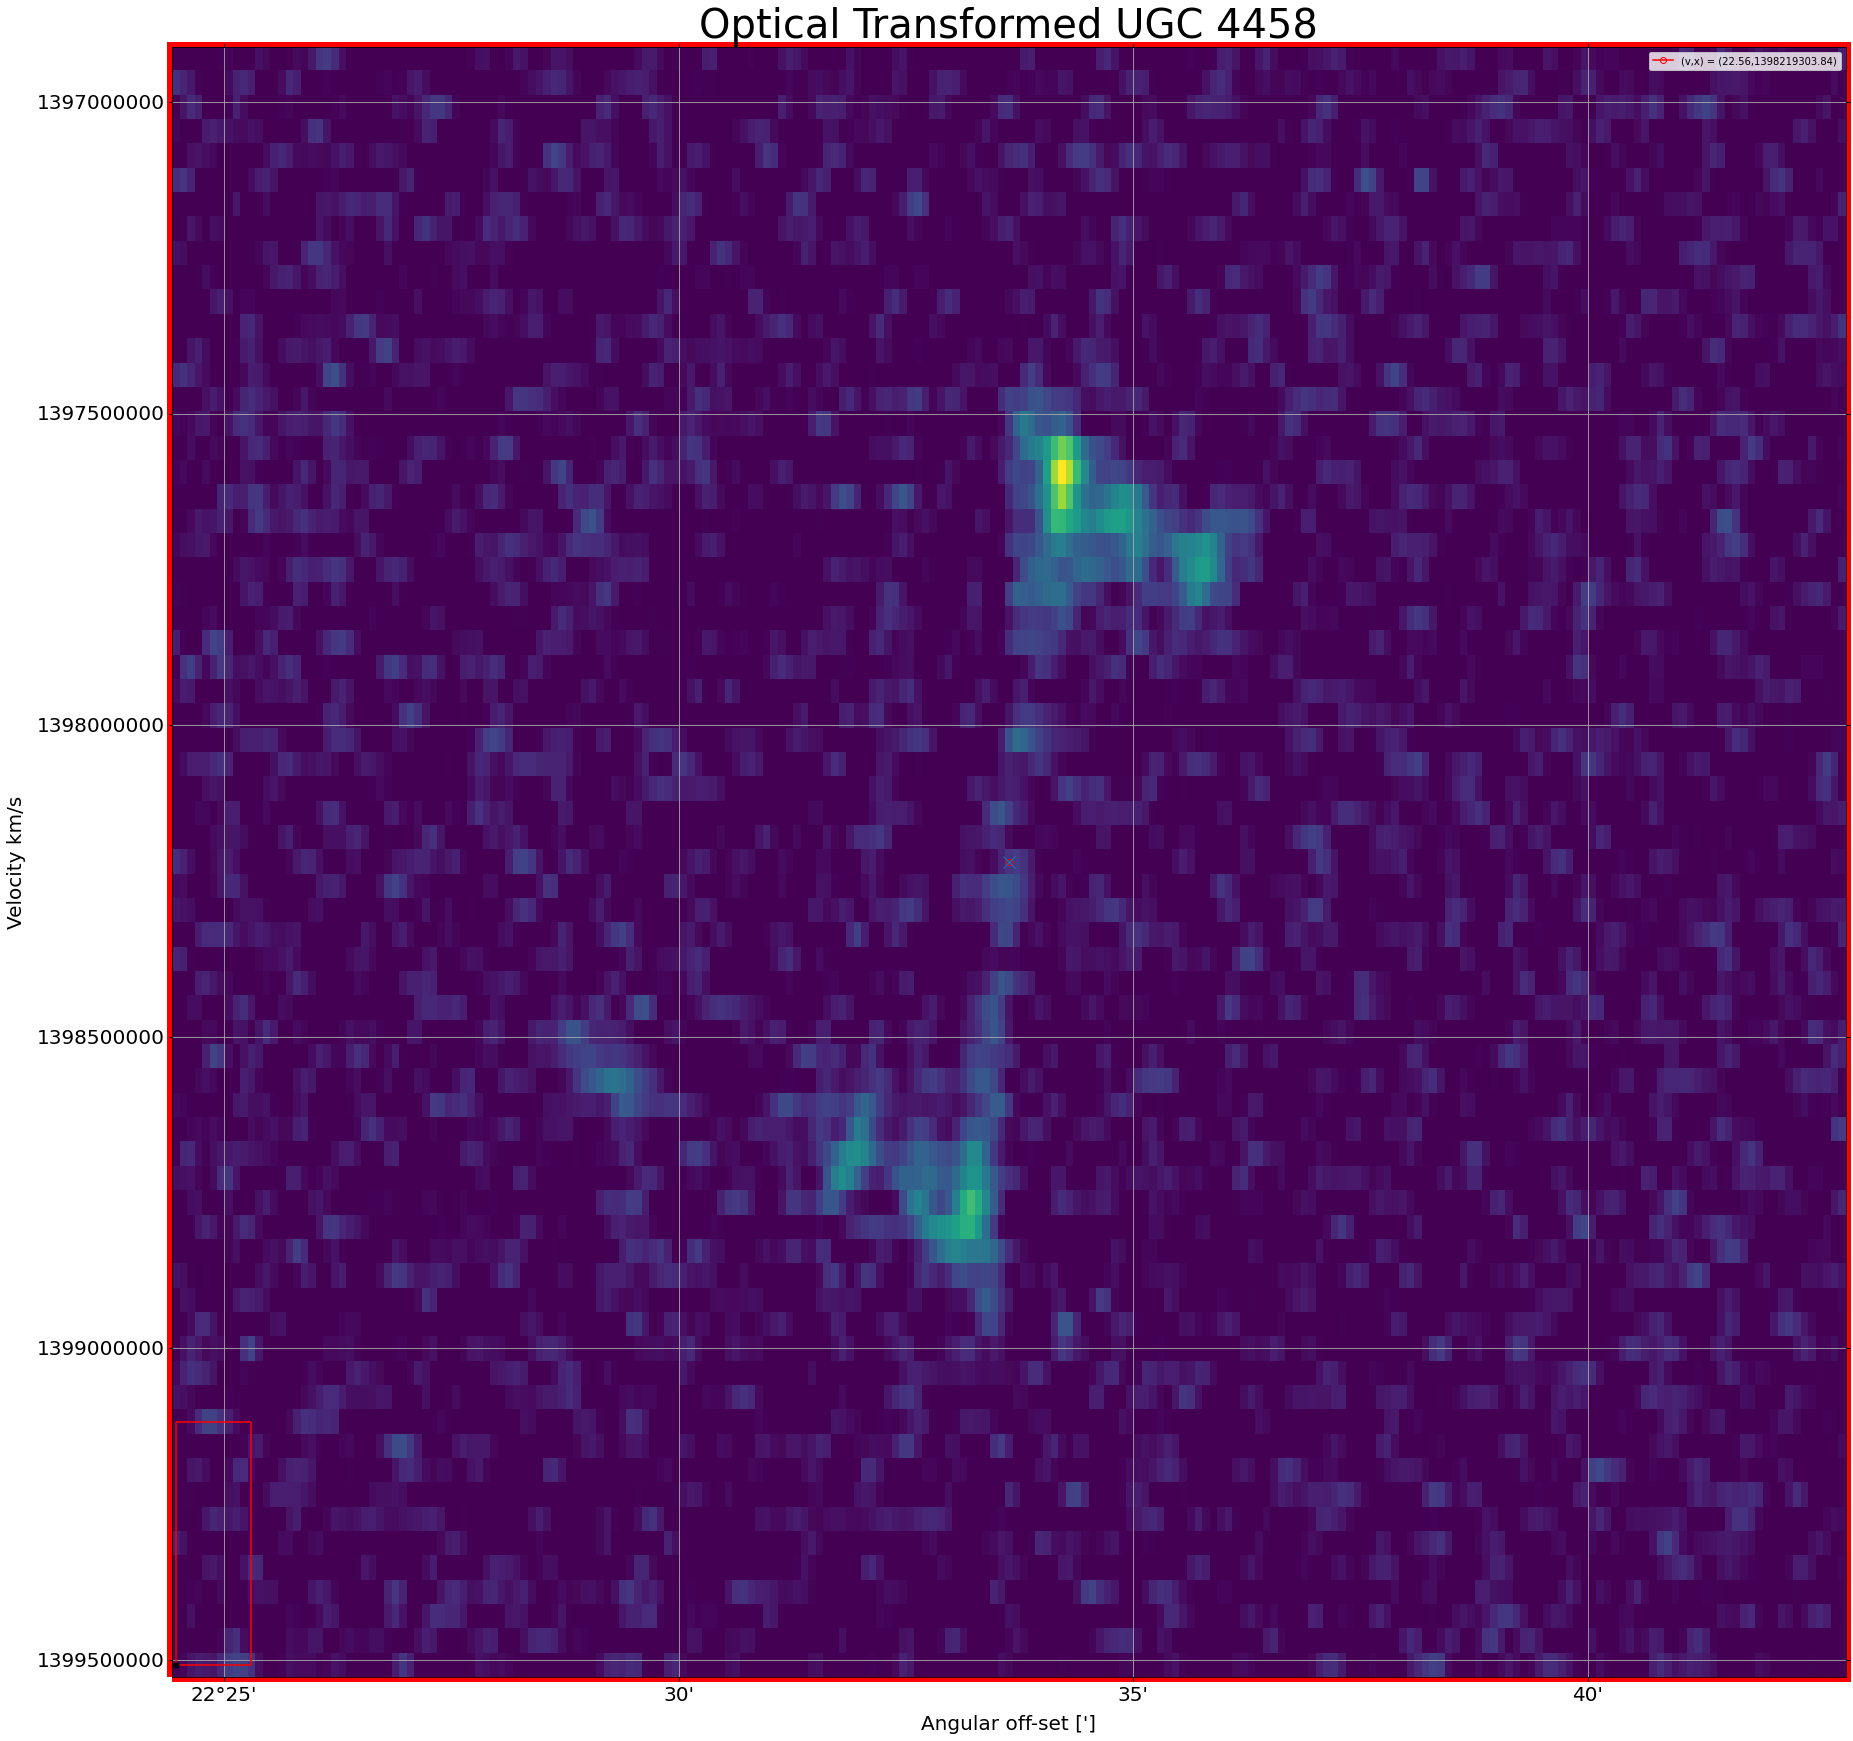

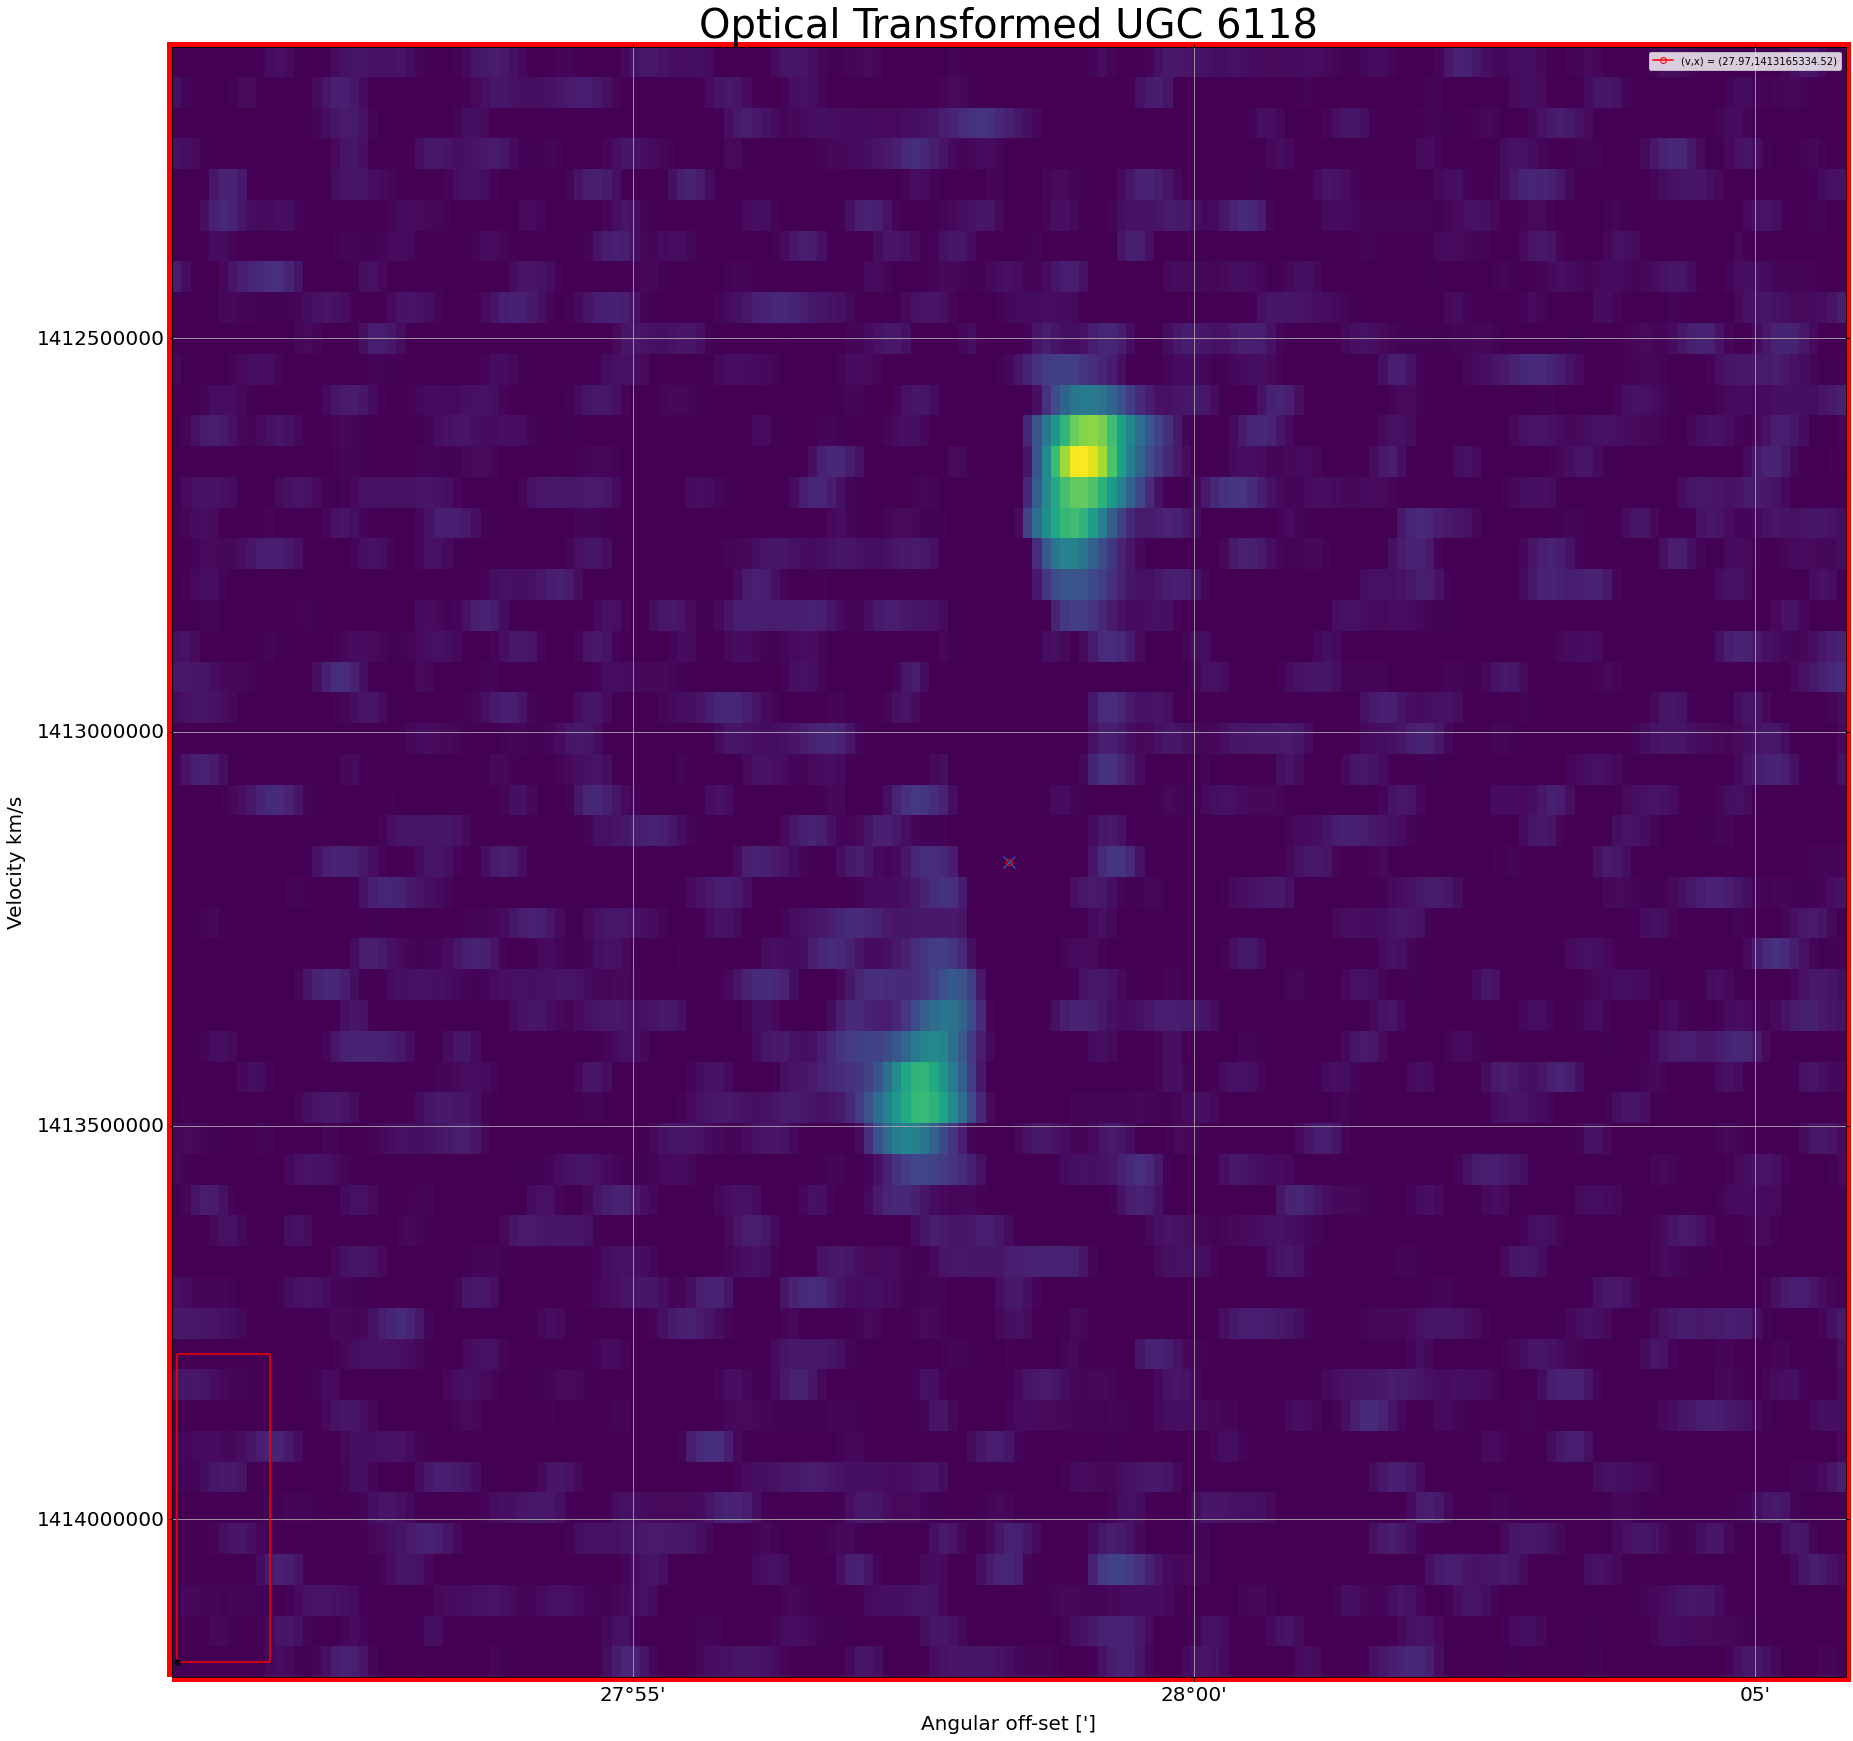

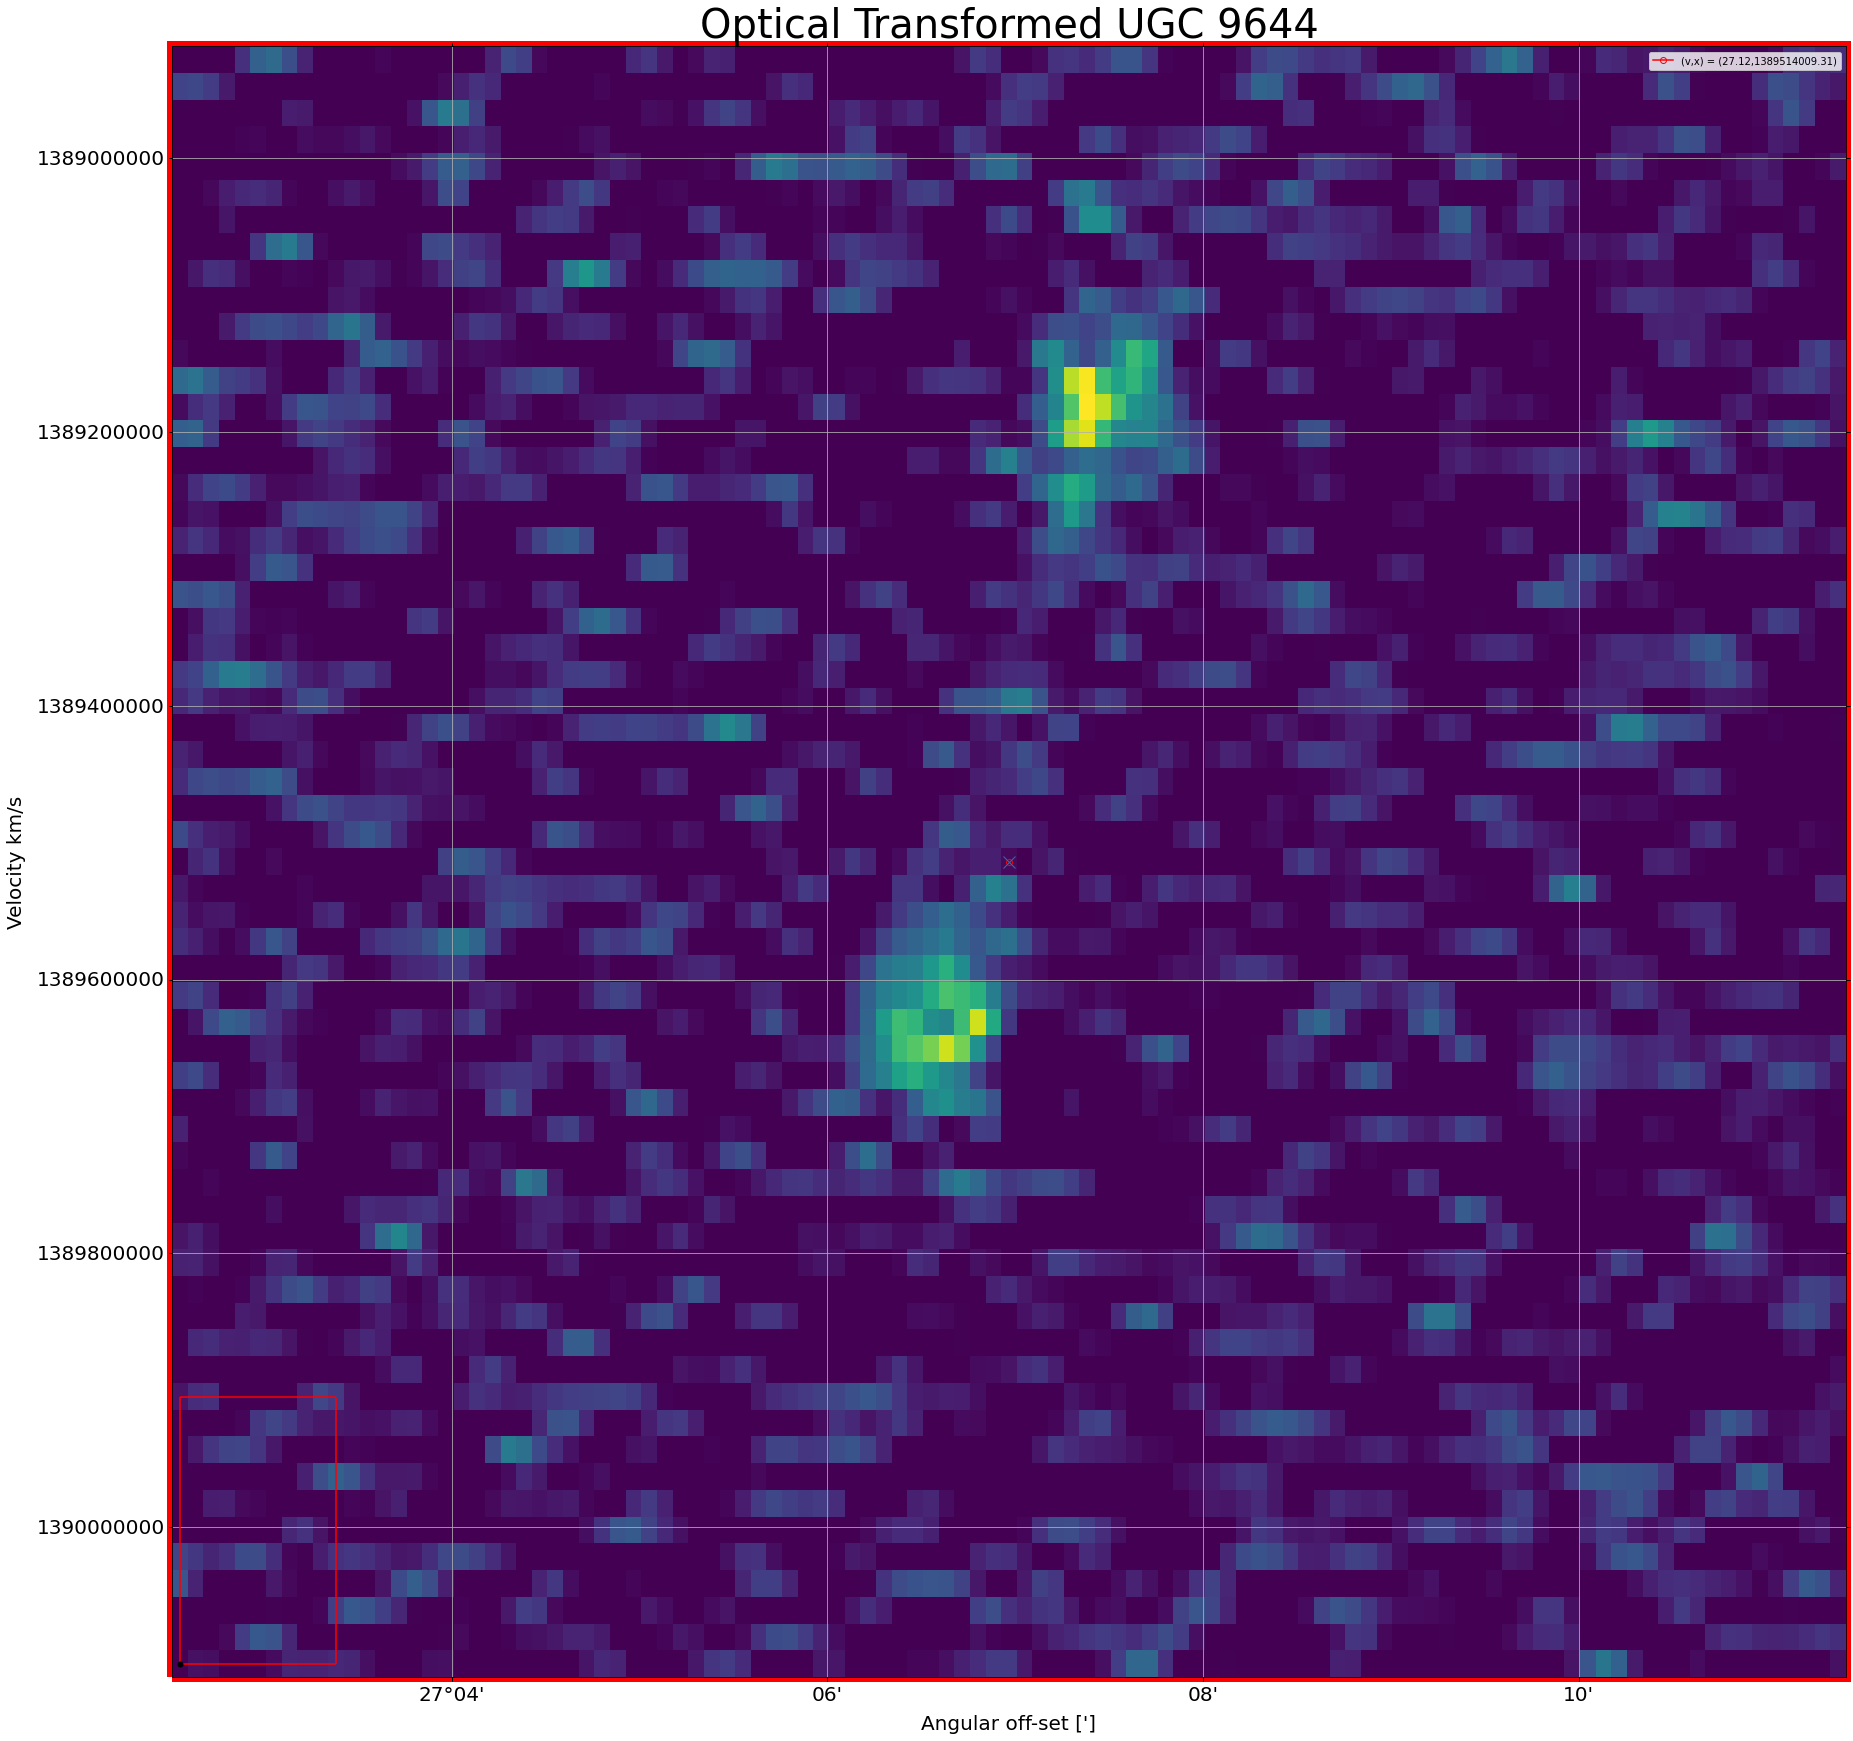

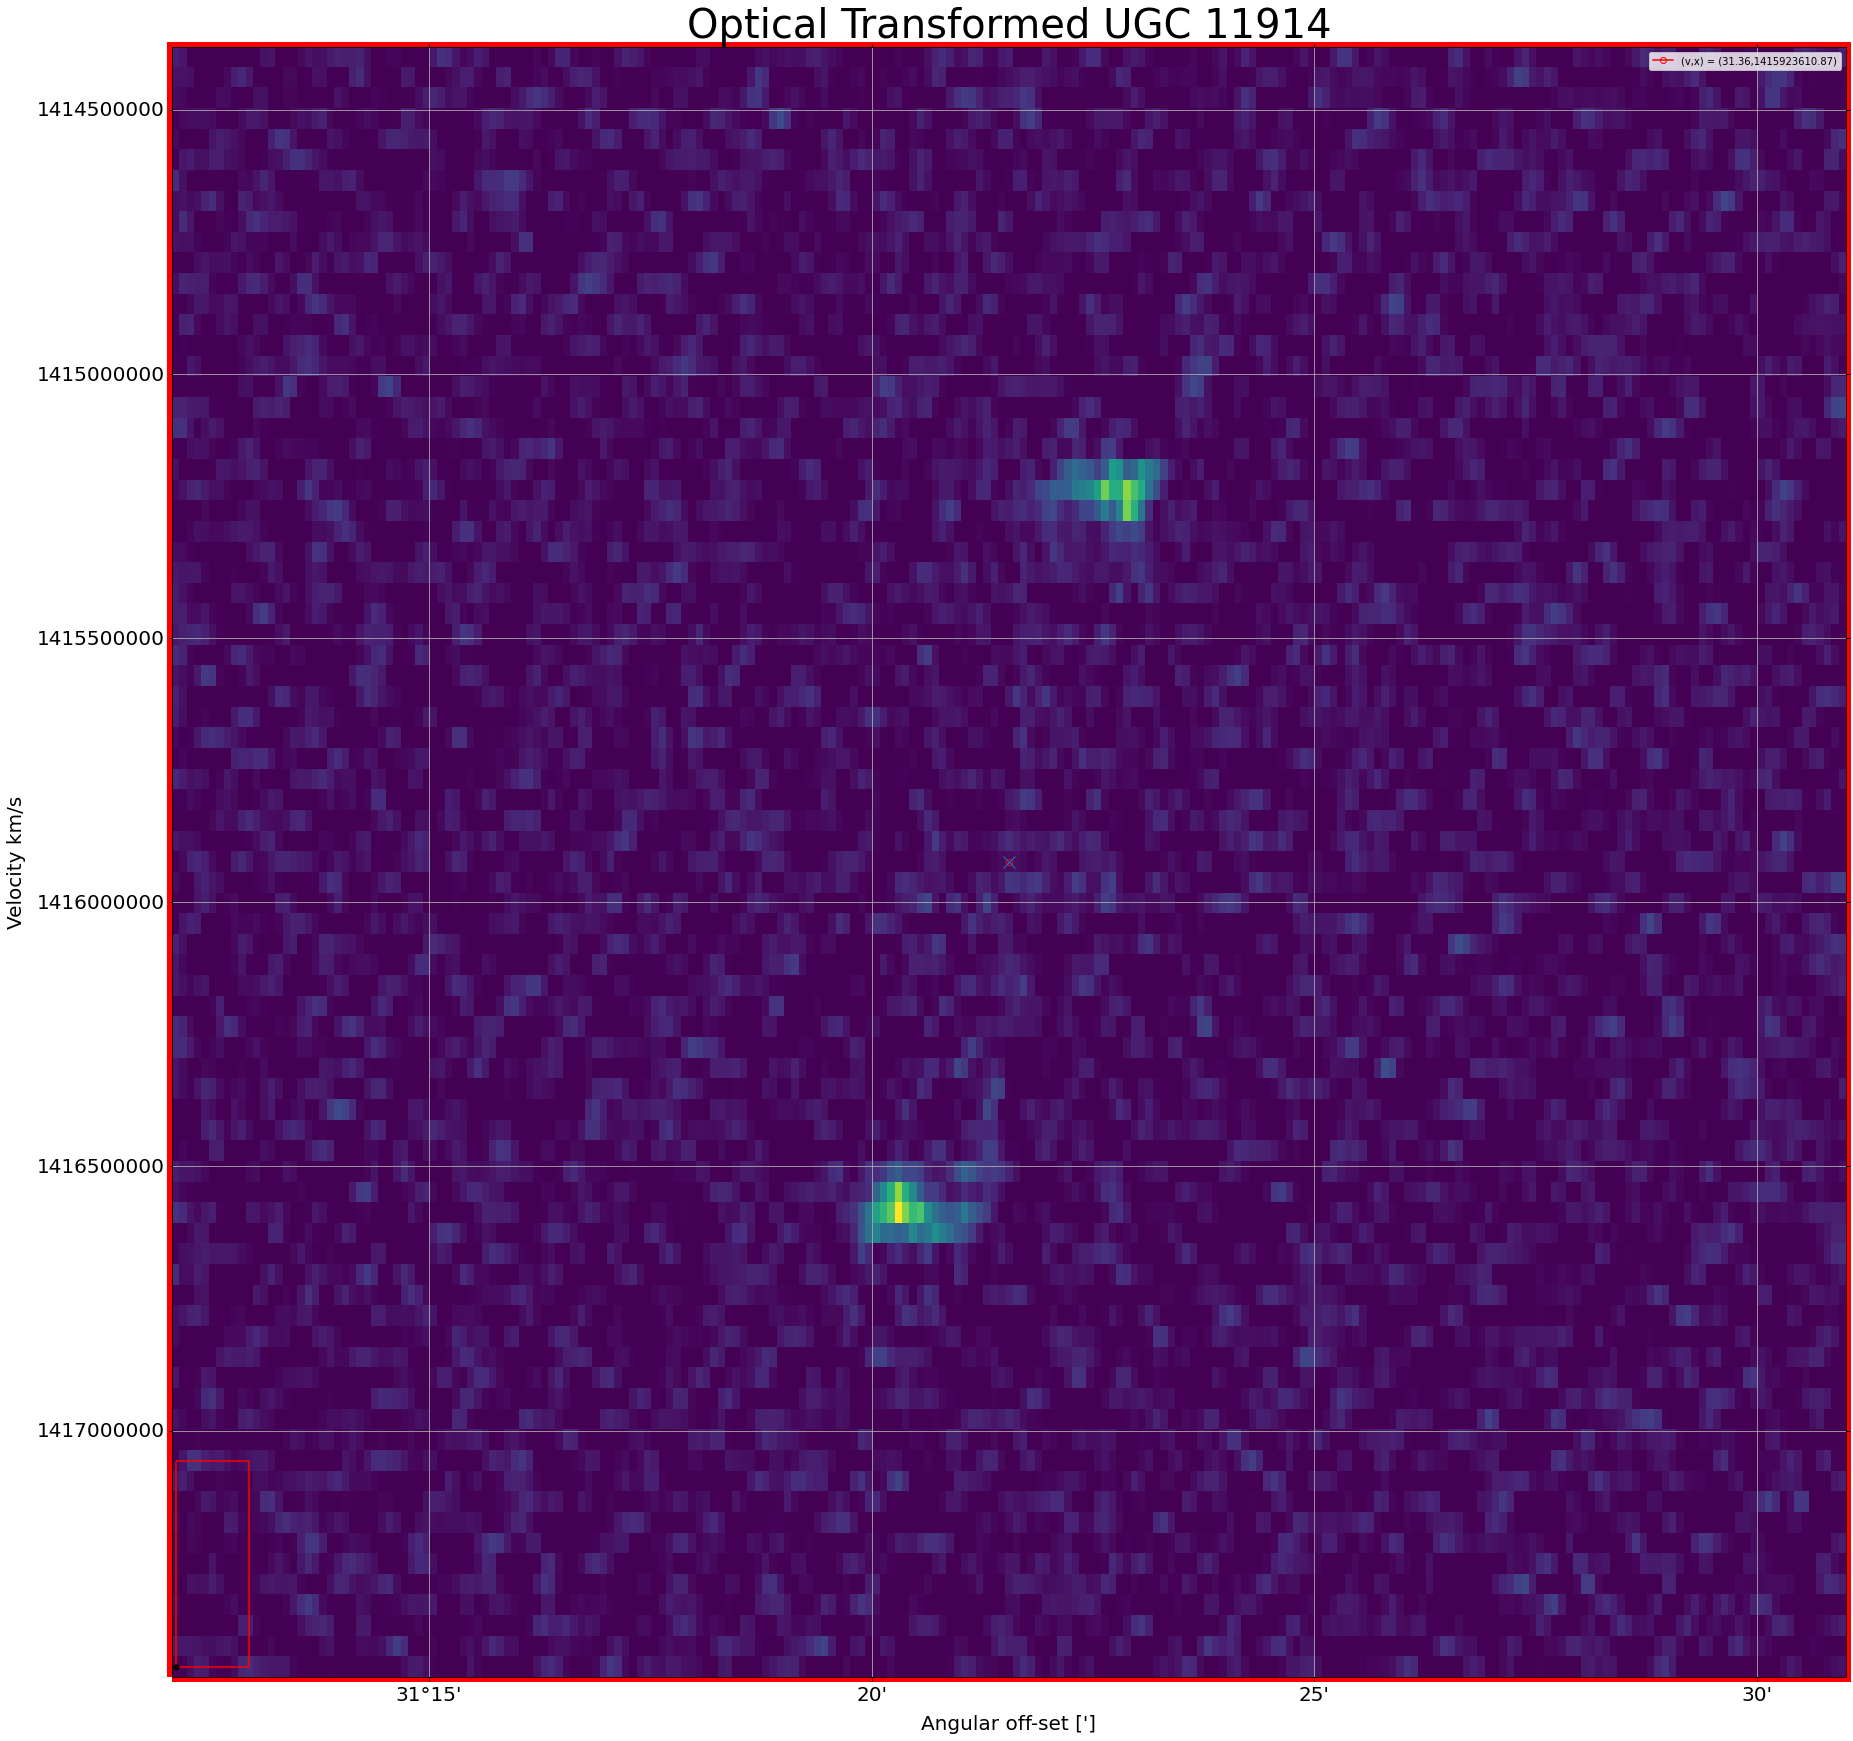

In [18]:
exclude = []
count = 0
skip = []
for file in sample:
    if file not in skip:
        try:
            ugcNumb = file
            f = plt.figure(figsize=(30,30))
            filename = f'{subroot}/UIRNEWu/UIRoNEWu{int(ugcNumb)}cl.fits'
            cube = SpectralCube.read(filename)
            XC,YC,VC = get_centre(cube,fits_cen=False)
            plotOnePV(cube,0)
            plt.plot(YC,VC,'x',markersize=12)
            plt.legend()
            plt.show()
            count+=1 
        except(FileNotFoundError):
            pass


In [22]:
freq2vel(1389514031.72189*u.Hz)

<Quantity -6520.04130118 km / s>